- **Репозиторий на GitHub:** [https://github.com/pacifistka/internet_store](https://github.com/pacifistka/internet_store)
- **Issues и улучшения:** [https://github.com/pacifistka/internet_store/issues](https://github.com/pacifistka/internet_store/issues)

# Исследование данных интернет-магазина «В один клик» и разработка прогнозной модели для удерживания активности постоянных клиентов

Изучение интернет-магазина «В один клик». Детальное изучение данных и разработка модели машинного обучения, которая поможет принимать объективное решение об удерживании активности постоянных клиентов.  Данная модель будет призвана  спрогнозировать вероятность снижения покупательской активности клиентов и выделить сегменты покупателей в зоне риска. Данное решение позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.


**Данные:**

В исследовании используются данные отдела цифровых технологий интернет-магазина «В один клик». Данные для работы находятся в нескольких таблицах:
- данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении,
- данные о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом,
- данные о времени (в минутах), которое покупатель провёл на сайте в течение периода,
- данные о среднемесячной прибыли продавца за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.


**Цели исследования:**
* Проанализировать данные интернет-магазина «В один клик»,
* Изучить взаимосвязь между имеющимися признаками в данных и подготовить данные для прогнозных моделей,
* Разработать модель, которая предскажет вероятность снижения покупательской активности.
* Выделить сегмент покупателей и предложить, как увеличить его покупательскую активность. 
* Дать рекомендации бизнесу: выводы и дополнительные предложения для выбранного сегмента покупателей.

##  **Исследование файлов с данными и изучение общей информации**

### Импортирем библиотеки pandas, matplotlib, seaborn, scipy, numpy, sklearn:

In [1]:
!pip install shap -q

In [2]:
!pip install phik -q

In [3]:
!pip install --upgrade scikit-learn -q

In [4]:
!pip install imbalanced-learn -q

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from scipy import stats as st
from scipy.stats import binom, norm, f_oneway
import matplotlib.ticker as ticker
from sklearn.preprocessing import (OneHotEncoder,
                                   OrdinalEncoder, 
                                   StandardScaler, 
                                   MinMaxScaler,
                                   RobustScaler)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (r2_score, f1_score, 
                            mean_absolute_error, 
                            mean_squared_error,  
                            accuracy_score, 
                            confusion_matrix, 
                            precision_score,
                            recall_score,
                            precision_recall_curve,
                            ConfusionMatrixDisplay, 
                            classification_report)
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import shap
import phik
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline as make_imb_pipeline
import os
from sklearn.ensemble import RandomForestClassifier

In [6]:
# константы
RANDOM_STATE = 42
TEST_SIZE = 0.25
CONST = 10

### Запишем данные из csv-файлов и сохраним их в датафреймы.

Пути к файлам (на сервере):    

`/datasets/market_file.csv` — данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведени,  
`/datasets/market_money.csv` —  данные о выручке, которую получает магазин с покупателя за период взаимодействия с сайтом,       
`/datasets/market_time.csv` — данные о времени (в минутах), которое покупатель провёл на сайте в течение периода,   
`/datasets/money.csv` — данные о среднемесячной прибыли продавца за последние 3 месяца по каждому покупателю. 

In [7]:
# создадим функцию для записи файлов, указав попытку загрузки с локального сервера, а затем с файл-сервера 
def write_read_csv(local, remote, sep): 
    try:
        return pd.read_csv(local, sep=sep)
    except FileNotFoundError:
        return pd.read_csv(remote, sep=sep)

In [8]:
# запишем данные из csv-файлов в датафреймы
market_file = write_read_csv('datasets/market_file.csv', '/datasets/market_file.csv', sep=',')
market_money = write_read_csv('datasets/market_money.csv', '/datasets/market_money.csv', sep=',')
market_time = write_read_csv('datasets/market_time.csv', '/datasets/market_time.csv', sep=',')
money = write_read_csv('datasets/money.csv', '/datasets/money.csv', sep=';')

### Изучим общую инфомацию о датафреймах и посмотрим их первые строки.

In [9]:
market_file.info()
market_file.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [10]:
market_money.info()
market_money.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [11]:
market_time.info()
market_time.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [12]:
money.info()
money.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   Прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


,id,Прибыль
0,215348,"0,98"
1,215349,"4,16"
2,215350,"3,13"
3,215351,"4,87"
4,215352,"4,21"


По общей информации и первым строкам видно, что датафрейм `market_file` содержит количественную и категориальную информацию о данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведени.  
Датафрем `market_money`  содержит о данные о выручке, которую получает магазин с покупателя за период взаимодействия с сайтом.   
Датафрем `market_time` содержит данные о времени (в минутах), которое покупатель провёл на сайте в течение периода.  
Датафрем `money` содержит данные о среднемесячной прибыли продавца за последние 3 месяца по каждому покупателю. 

Данные в таблицах соответствуют описанию.

Перед началом форматирования датафреймов сделаем их независимые копии с исходными данными:

In [13]:
market_file_backup = market_file.copy(deep=True)
market_money_backup = market_money.copy(deep=True)
market_time_backup = market_time.copy(deep=True)
money_backup = money.copy(deep=True)

Также во всех  датафреймах необходимо переименовать столбцы в соответсвии со стилем кода:

In [14]:
market_file.columns = ['client_id', 
                      'buyer_activity', 
                      'service_type', 
                      'allow_reporting', 
                      'ads_6_months', 
                      'ads_this_month', 
                      'duration', 
                      'promotional_in_purchases',
                      'popular_category',
                      'avg_category_per_visit',
                      'unpaid_products_3_months',
                      'service_error_3_months',
                      'pages_per_visit']

market_money.columns = ['client_id',
                        'period', 
                        'income']

market_time.columns = ['client_id',
                       'period',  
                       'duration_in_mins']

money.columns = ['client_id',
                 'profit']

**Вывод по этапу "Исследование файлов с данными и изучение общей информации":**

На данном этапе была просмотрена общая информация и первые строки датафреймов.      
Также были переименованы все столбцы в соответсвии со стилем кода в датафреймах `market_file`, `market_money`, `market_time`, `money`.

##  Предобработка данных

### Проверка наличия пропущенных значений и дубликатов в датафреймах.

Перед обработкой пропущенных значений и дубликатов создадим копии датафреймов `market_file`, `market_money`, `market_time`, `money` и зафиксируем их размер до преобразования:

In [15]:
# создаем копии датасетов до преобразования
temp_market_file = market_file.copy() 
temp_market_money = market_money.copy() 
temp_market_time = market_time.copy() 
temp_money = money.copy() 

In [16]:
# фиксируем размер датасетов до преобразования
print(f'Длина датасета market_file: {len(temp_market_file)}\
\nДлина датасета market_money: {len(temp_market_money)}\
\nДлина датасета market_time: {len(temp_market_time)}\
\nДлина датасета money: {len(temp_money)}')

Длина датасета market_file: 1300
Длина датасета market_money: 3900
Длина датасета market_time: 2600
Длина датасета money: 1300


#### Проверка пропусков в датафреймах.

Поcмотрим соотношения пропусков в каждом столбце датафреймов `market_file`, `market_money`, `market_time`, `money`:

In [17]:
def isna_table(dataframe):
    return pd.DataFrame(round(dataframe.isna().mean()*100,)).style.background_gradient('coolwarm')

display(
    isna_table(market_file).set_caption("Данные о поведении покупателя на сайте"),
    isna_table(market_money).set_caption("Данные о выручке с каждого покупателя"),
    isna_table(market_time).set_caption("Данные о времени , проведенном на сайте"),
    isna_table(money).set_caption("Данные о среднемесячной прибыли продавца")
)

,0
client_id,0.000000
buyer_activity,0.000000
service_type,0.000000
allow_reporting,0.000000
ads_6_months,0.000000
ads_this_month,0.000000
duration,0.000000
promotional_in_purchases,0.000000
popular_category,0.000000
avg_category_per_visit,0.000000


,0
client_id,0.000000
period,0.000000
income,0.000000


,0
client_id,0.000000
period,0.000000
duration_in_mins,0.000000


,0
client_id,0.000000
profit,0.000000


**Вывод:** пропуски отсутсвуют по всех столбцах датафреймов`market_file`, `market_money`, `market_time`, `money`.

#### Обработка дубликатов в датафреймах.

Исследуем датафреймы `market_file`, `market_money`, `market_time`, `money` на явные дубликаты.

In [18]:
market_file.duplicated().sum()

0

In [19]:
market_money.duplicated().sum()

0

In [20]:
market_time.duplicated().sum()

0

In [21]:
money.duplicated().sum()

0

Явные дубликаты отсутсвуют в во всех 4-х датафреймах `market_file`, `market_money`, `market_time`, `money`. Проверим данные датафреймов на Неявные дубликаты:

In [22]:
# проверка в "market_file" дубликатов в уникальных значениях столбца "Идентификационный номер клиента"
market_file.loc[(market_file[['client_id']].duplicated())]

,client_id,buyer_activity,service_type,allow_reporting,ads_6_months,ads_this_month,duration,promotional_in_purchases,popular_category,avg_category_per_visit,unpaid_products_3_months,service_error_3_months,pages_per_visit


In [23]:
# проверка  в "money" дубликатов в уникальных значениях столбца "Идентификационный номер клиента"
money.loc[(money[['client_id']].duplicated())]

,client_id,profit


В датасетах `market_money`, `market_time` признак "Идентификационный номер клиента"  может повторяться, так как на одного пользователя указаны разные периоды и соответственно несколько строк. 

Также проверим категориальные столбцы датасетов на выявление ошибок в названиях категорий трех датсетов `market_file`, `market_money`, `market_time` (в датасете `money` только числовой признак):

In [24]:
# напишем функцию чтобы перебрать каждый столбец с выводом уникальных значений на экран 
def get_unique_cats(cat_cols):
    for column in cat_cols:
        unique_vals = cat_cols[column].unique()
        print(f"Уникальные значения в колонке '{column}': {unique_vals}")

In [25]:
# выбор списка колонок c кат.данными в датасетах market_file, market_money и market_time
cat_columns_market_file = market_file[['buyer_activity', 'service_type', 'allow_reporting', 'popular_category']]
cat_columns_market_money = market_money[['period']]
cat_columns_market_time = market_time[['period']]

# выводим на экран уникальные категории каждой кат.колонки по трем датасетам 
get_unique_cats(cat_columns_market_file)
get_unique_cats(cat_columns_market_money)
get_unique_cats(cat_columns_market_time)

Уникальные значения в колонке 'buyer_activity': ['Снизилась' 'Прежний уровень']
Уникальные значения в колонке 'service_type': ['премиум' 'стандартт' 'стандарт']
Уникальные значения в колонке 'allow_reporting': ['да' 'нет']
Уникальные значения в колонке 'popular_category': ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']
Уникальные значения в колонке 'period': ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']
Уникальные значения в колонке 'period': ['текущий_месяц' 'предыдцщий_месяц']


Найдены ошибки в категорях в столбцах:
1) `service_type` датасета `market_file` в названии категории 'стандартт', его необходимо заменить на 'стандарт',
2) `period` датасета `market_time` в названии категории 'предыдцщий_месяц', его необходимо заменить на 'предыдущий_месяц'.

In [26]:
market_file['service_type'] = market_file['service_type'].replace('стандартт', 'стандарт')
market_time['period'] = market_time['period'].replace('предыдцщий_месяц', 'предыдущий_месяц')
market_file['popular_category'] = market_file['popular_category'].replace('Косметика и аксесуары', 'Косметика и аксессуары')

Сопоставим размеры датасетов `market_file`, `market_money`, `market_time` и их копий до преобразований: `temp_market_file`, `temp_market_money`, `temp_market_time`, чтобы убедиться в верной предобработке данных:

In [27]:
# функция для подсчета разницы датасетов до и после предобрадотки данных 
def count_length_of_data(df_name, temp_df, df):
    return print(f'Разница длины датафрейма {df_name} до и после обработки: {len(temp_df)-len(df)} строк(и)') 

count_length_of_data("market_file", temp_market_file, market_file)
count_length_of_data("market_money", temp_market_money, market_money)
count_length_of_data("market_time", temp_market_time, market_time)

Разница длины датафрейма market_file до и после обработки: 0 строк(и)
Разница длины датафрейма market_money до и после обработки: 0 строк(и)
Разница длины датафрейма market_time до и после обработки: 0 строк(и)


**Вывод:** проверка на пропуски, явные и неявные дубликаты категориальных столбцов в датасетах  `market_file`, `market_money`, `market_time`  не выявила дубликатов и пропусков. В датафреймах `market_file` и `market_time` были изменены названия категорий. Длины предобработтых датасетов не изменились. 

### Изменение типа данных в столбцах.

Изменим тип данных в датафрейме `money`в столбце `profit` (прибыль — значение прибыли в условных единицах) с типа object на тип float. А в датафреймах `market_file`, `market_money`, `market_time` оставим текущие типы данных: они соответствуют знаениям в таблицах.  

In [28]:
money['profit'] = money['profit'].astype(str).str.replace(',', '.') # меняем запятые на точки в выбр.столбцах
money['profit'] = pd.to_numeric(money['profit'], errors='coerce')   # меняем тип столцов на float 

Проверим не появились ли пропуски (NaN) после преобразования строк в числовые данные в датафрейме `money`:

In [29]:
print(f" В датасете 'money' признак 'profit' типа {money['profit'].dtype}, количество неудачных преобразований: {money['profit'].isna().sum()}")

 В датасете 'money' признак 'profit' типа float64, количество неудачных преобразований: 0


**Вывод:** был изменен тип данных в датафрейме `money`в столбце `Прибыль` с типа object на тип float без появлений пропусков (NaN).

**Вывод по этапу "Предобработки данных":**

На этапе предобработки данных :
* определили, что пропуски и дубликаты отсутсвуют по всех столбцах датафреймов `market_file`, `market_money`, `market_time`, `money`.
* проверены все категориальные столбцы в датафреймах `market_file`, `market_money`, `market_time`.  В датафреймах `market_file` и `market_time` были изменены названия категорий `service_type` и `period`.
* изменен тип данных в датафрейме `money`в столбце `Прибыль` с типа object на тип float без появлений пропусков (NaN).

## Исследовательский анализ данных

На данном этапе проведем статистический анализ всех признаков каждого датасета и построим для них графики. Проверим данные на выбросы, необычное распределение количественных признаков. Отберем клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период. 

### Статистический анализ признаков датасетов.

Для выполнения статистического анализа для каждого количественного признака сделаем анализ базовых статистик, таких как среднее сначение, значения квартилей и т.д. Анализ будем проводить для датафреймов `market_file`, `market_money`, `market_time`, `money`.

In [30]:
# запишем функцию для вывода статистик для каждого параметра
def stats_describe(name, df, columns):
    stats = df[columns].describe().T
    stats = stats.style.set_caption(f"<b>{name}</b>") 
    return stats

In [31]:
# отдельно сохраним количественные показатели для всех датасетов в переменные, тк в дальнейшем они понадобятся
num_cols_market_file = market_file.select_dtypes(include=['int64', 'float64']).columns.drop('client_id') 
num_cols_market_money = market_money.select_dtypes(include=['int64', 'float64']).columns.drop('client_id')
num_cols_market_time = market_time.select_dtypes(include=['int64', 'float64']).columns.drop('client_id')
num_cols_money = money.select_dtypes(include=['int64', 'float64']).columns.drop('client_id')

Отобразим статистики для каждого параметра во всех 4-х датасетах:

In [32]:
stats_describe('Поведение покупателя на сайте:', market_file, num_cols_market_file)

,count,mean,std,min,25%,50%,75%,max
ads_6_months,1300.000000,4.253769,1.014814,0.900000,3.700000,4.200000,4.900000,6.600000
ads_this_month,1300.000000,4.011538,0.696868,3.000000,4.000000,4.000000,4.000000,5.000000
duration,1300.000000,601.898462,249.856289,110.000000,405.500000,606.000000,806.000000,1079.000000
promotional_in_purchases,1300.000000,0.319808,0.249843,0.000000,0.170000,0.240000,0.300000,0.990000
avg_category_per_visit,1300.000000,3.270000,1.355350,1.000000,2.000000,3.000000,4.000000,6.000000
unpaid_products_3_months,1300.000000,2.840000,1.971451,0.000000,1.000000,3.000000,4.000000,10.000000
service_error_3_months,1300.000000,4.185385,1.955298,0.000000,3.000000,4.000000,6.000000,9.000000
pages_per_visit,1300.000000,8.176923,3.978126,1.000000,5.000000,8.000000,11.000000,20.000000


In [33]:
stats_describe('Выручка магазина с каждого покупателя:', market_money, num_cols_market_money)

,count,mean,std,min,25%,50%,75%,max
income,3900.000000,5025.696051,1777.704104,0.000000,4590.150000,4957.500000,5363.000000,106862.200000


In [34]:
stats_describe('Время покупателя на сайте:', market_time, num_cols_market_time)

,count,mean,std,min,25%,50%,75%,max
duration_in_mins,2600.000000,13.336154,4.080198,4.000000,10.000000,13.000000,16.000000,23.000000


In [35]:
stats_describe('Прибыль магазина с каждого покупателя за месяц:', money, num_cols_money)

,count,mean,std,min,25%,50%,75%,max
profit,1300.000000,3.996631,1.013722,0.860000,3.300000,4.045000,4.670000,7.430000


**Вывод по статистическому анализу признаков датасетов:**  

Поведение покупателя на сайте:
* `ads_6_months`(число рассылок, звонков, показов рекламы на клиента за 6 месяцев): распределение близко к нормальному, медиана и среднее очень близки - 4.25 (среднее) и 4.20 (медиана). Диапозон показателя от 0.9 до 6.6. Стандартное отклонение - 1.
* `ads_this_month` (количество маркетинговых коммуникаций в текущем месяце): показатель стабилен, медиана и среднее совпадают - по 4.0  Диапазон узкий: 3.0–5.0. Стандартное отклонение - 0.69.
* `duration` (количество дней с момента регистрации покупателя на сайте): показатель показывает большой разброс, медиана и среднее близки - 606 и 601 соответственно.  Диапозон показателя от 110 до 1079. Стандартное отклонение - 250.
* `promotional_in_purchases` (доля покупок по акциям): сильная правосторонняя асимметрия (среднее 0.32 > медианы 0.24). Стандартное отклонение=0.25 относительно велик для среднего значения. 75% покупателей имеют долю ≤30%. Максимум  - 99% указывает на сегмент "акционных" покупателей.
* `avg_category_per_visit` (ср. количество категорий, которое покупатель смотрит за визит в последнеий месяц): распределение близко к нормальному (среднее 3.27 близок к медиане 3.0). Стандартное отклонение=1.36 приемлем для данной метрики. 50% покупателей просматривают 2-4 категории за визит.
* `unpaid_products_3_months` (число неоплаченных товаров в корзине за последние 3 месяца): заметный разброс (ст.отклонение=1.97 при среднем 2.84). Медиана=3.0. Половина значений между 1.0 и 4.0. Максимум  - 10 товаров указывает на проблемных покупателей.
* `service_error_3_months` (число сбоев у покупателя во время посещения сайта за последние 3 месяца): среднее 4.19 близко к медиане 4.0. Умеренный разброс (ст.отклонение=1.96). 75% покупателей сталкиваются с не более чем 6 сбоями. Максимум 9 ошибок требует исследования.
* `pages_per_visit` (ср. количество страниц, которое покупатель смотрит за визит за последние 3 месяца):  широкий разброс (большое ст.отклоление=3.98 при среднем 8.18). Медиана=8.0. 50% значений между 5.0 и 11.0. Максимум  - 20 страниц показывает высокую вовлечённость.

Выручка магазина с каждого покупателя:
* `income`(сумма выручки за период в условных единицах): сильная асимметрия распределения данных (среднее 5025.7 > медиана 4957.5), очень высокое ст.отклонение=1777.7, что говорит о неоднородности покупателей. Максимальное значение 106862.2 — экстремальный выброс (в 20 раз выше 75-го перцентиля), требует проверки на ошибку данных.

Время покупателя на сайте:
* `duration_in_mins` (время, проведённое на сайте, в минутах): распределение близко к нормальному (среднее 13.34 ≈ медиана 13.0). Умеренное стандартное отклонение=4.08, что нормальон для поведенческих метрик как "время на сайте". Диапазон: От 4 до 23 минут. Половина пользователей (25%-75%) проводят на сайте 10-16 минут.

Прибыль магазина с каждого покупателя за месяц:
* `profit` (значение прибыли в условных единицах): слабая асимметрия (медиана 4.045 > среднее 3.997), умеренное стандартное отклонение=1.01. Диапазон: От 0.86 до 7.43 — большая вариативность рентабельности.  Половина покупателей генерирует прибыль в диапазоне 3.3-4.67 ед.


Проблемы в данных:
* необходимо исследовать природу выбросов в выручке, так как возможны ошибки данных или эксклюзивные богатые покупатели.

### Графики количественных и категориальных признаков.

#### Количественные признаки и их графики.

Построим гистрограммы распределения всех количественных признаков по  `market_file`, `market_money`, `market_time`, `money`:

In [36]:
# разделим признаки по типам неприрывные признаки и дискретные в market_file
continuous_cols = ['ads_6_months', 'duration', 'promotional_in_purchases']
discrete_cols = ['ads_this_month', 'avg_category_per_visit', 
                'unpaid_products_3_months', 'service_error_3_months', 
                'pages_per_visit']

# создадим словарь с подписями (название, ось X, ось Y) в market_file
labels = {
    'ads_6_months': ['Реклама за 6 месяцев', 'Число рассылок, звонков, рекламы, шт', 'Количество покупателей, чел.'],
    'ads_this_month': ['Реклама в текущем месяце', 'Число рассылок, звонков, рекламы, шт', 'Количество покупателейб чел.'],
    'duration': ['Длительность регистрации', 'Дней', 'Количество покупателей, чел.'],
    'promotional_in_purchases': ['Покупки по акциям', 'Доля промо-покупок', 'Количество покупателей, чел.'],
    'avg_category_per_visit': ['Категорий за визит', 'Количество категорий, шт.', 'Количество покупателей, чел.'],
    'unpaid_products_3_months': ['Неоплаченные товары', 'Количество товаров, шт.', 'Количество покупателей, чел.'],
    'service_error_3_months': ['Ошибки сервиса', 'Количество ошибок, шт.', 'Количество покупателей, чел.'],
    'pages_per_visit': ['Страниц за визит', 'Количество страниц, шт.', 'Количество покупателей, чел.']
}

In [37]:
# функция для построения графиков распределения по показателям
def plot_enhanced(df, cols, labels_dict, plot_type='auto', figsize=(16, 12)):
    
    n_cols = min(3, len(cols))  # Не более 3 колонок
    n_rows = (len(cols) + n_cols - 1) // n_cols
    
    # автоподбор размера для одиночного графика
    if len(cols) == 1:
        figsize = (figsize[0], 5)  # Фиксированная высота для одного графика
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = np.array(axes).flatten()  # Для единообразия обработки
    
    for i, col in enumerate(cols):
        ax = axes[i]
        
        # автовыбор типа графика
        if plot_type == 'auto':
            current_plot_type = 'count' if df[col].nunique() <= 15 else 'hist'
        else:
            current_plot_type = plot_type
        
        # построение графиков
        if current_plot_type == 'count':
            sns.countplot(x=col, data=df, ax=ax, color='#DDA00D', alpha=0.85)
            for p in ax.patches:
                ax.annotate(f'{p.get_height():.0f}', 
                           (p.get_x() + p.get_width() / 2., p.get_height()),
                           ha='center', va='center', 
                           xytext=(0, 5), 
                           textcoords='offset points',
                           fontsize=9)
        else:
            sns.histplot(df[col], ax=ax, color='#DDA00D', alpha=0.85, kde=True, bins=15)
        
        # установка подписей
        title, xlabel, ylabel = labels_dict.get(col, ['', '', ''])
        ax.set_title(title, fontsize=12)
        ax.set_xlabel(xlabel, fontsize=10)
        ax.set_ylabel(ylabel, fontsize=10)
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        ax.tick_params(labelsize=9)
    
    
    # единый заголовок для всей фигуры
    fig.suptitle('Анализ распределения показателей', 
                 fontsize=16, 
                 fontweight='bold',
                 y=0.98 if len(cols) > 1 else 0.95)  # Разное положение для 1 и >1 графиков
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9 if len(cols) > 1 else 0.85)  # Регулировка верхнего отступа
    plt.show()
    
    # вывод статистики (в этом случае использую метод print())
    print("\nИнтерпретация распределений:")
    for col in cols:
        stats = [
            f"Среднее: {df[col].mean():.2f}",
            f"Медиана: {df[col].median():.2f}",
            f"Диапазон: от {df[col].min():.2f} до {df[col].max():.2f}",
            f"Стандартное отклонение: {df[col].std():.2f}"
        ]
        print(f"\n• {labels_dict[col][0]}:\n  - " + "\n  - ".join(stats))

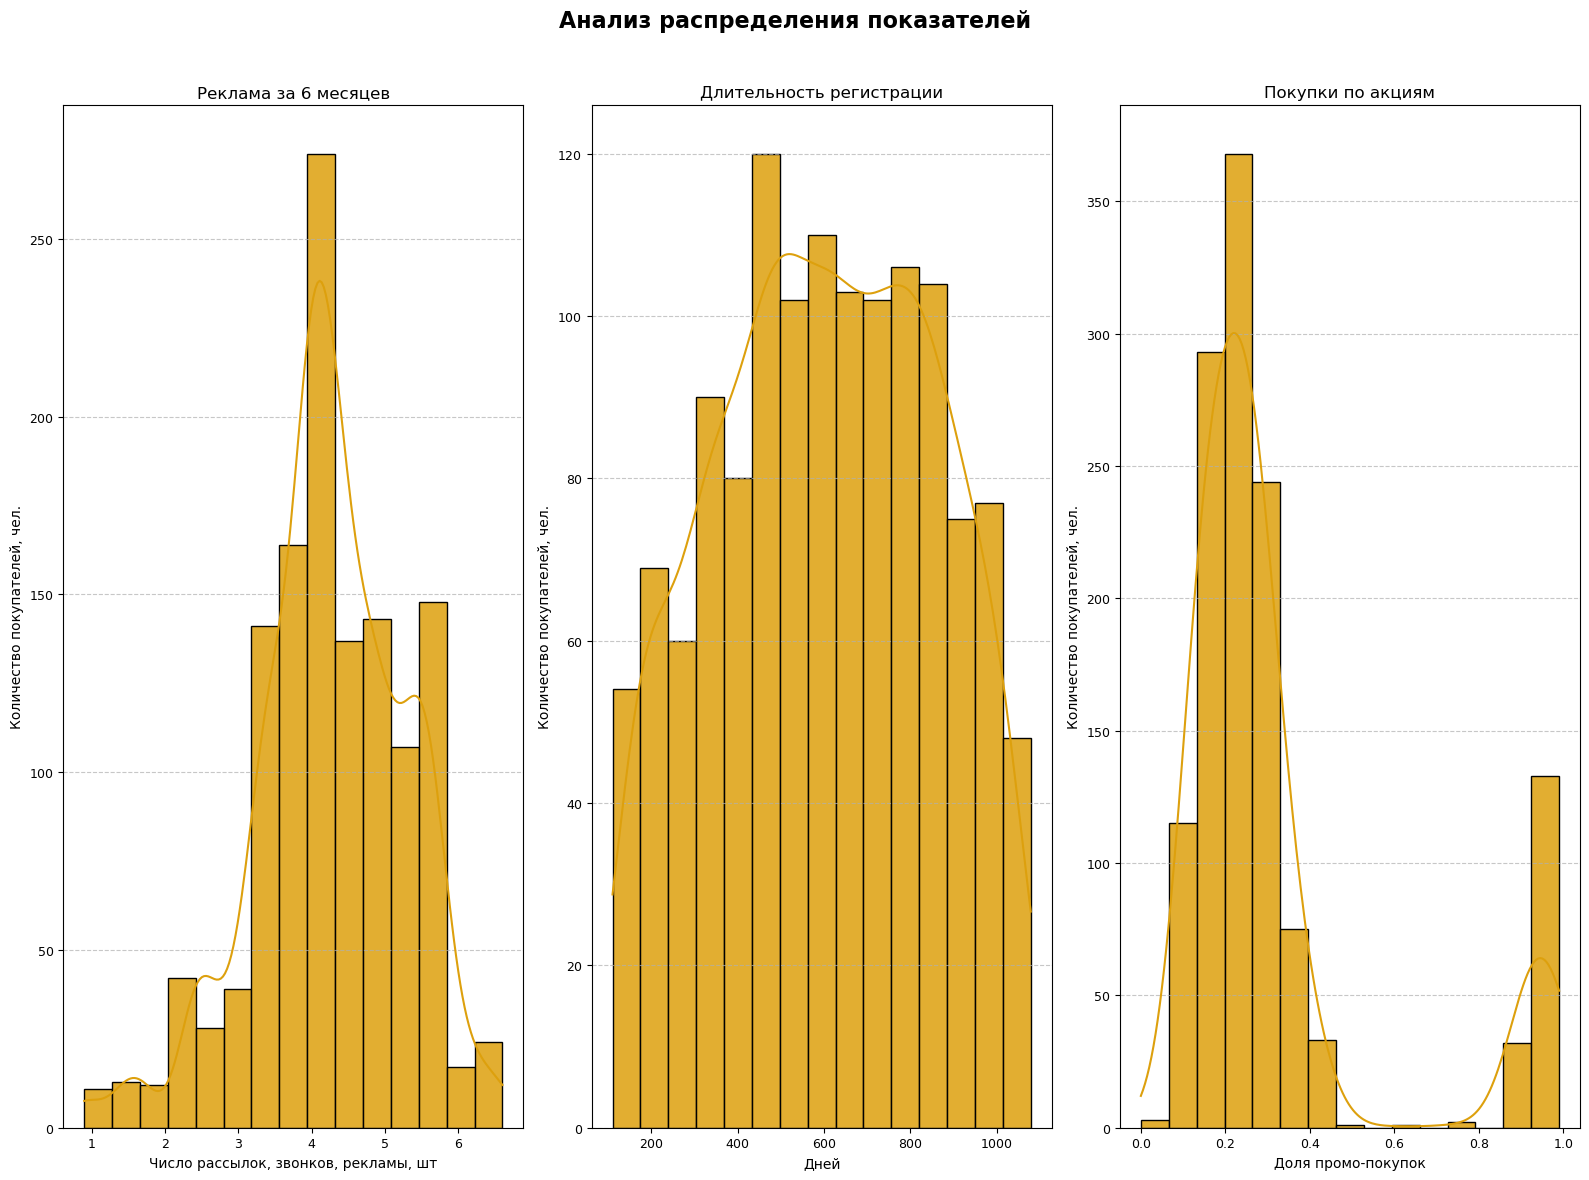


Интерпретация распределений:

• Реклама за 6 месяцев:
  - Среднее: 4.25
  - Медиана: 4.20
  - Диапазон: от 0.90 до 6.60
  - Стандартное отклонение: 1.01

• Длительность регистрации:
  - Среднее: 601.90
  - Медиана: 606.00
  - Диапазон: от 110.00 до 1079.00
  - Стандартное отклонение: 249.86

• Покупки по акциям:
  - Среднее: 0.32
  - Медиана: 0.24
  - Диапазон: от 0.00 до 0.99
  - Стандартное отклонение: 0.25


In [38]:
# строим графики для непрерывных признаков market_file
plot_enhanced(market_file, continuous_cols, labels)

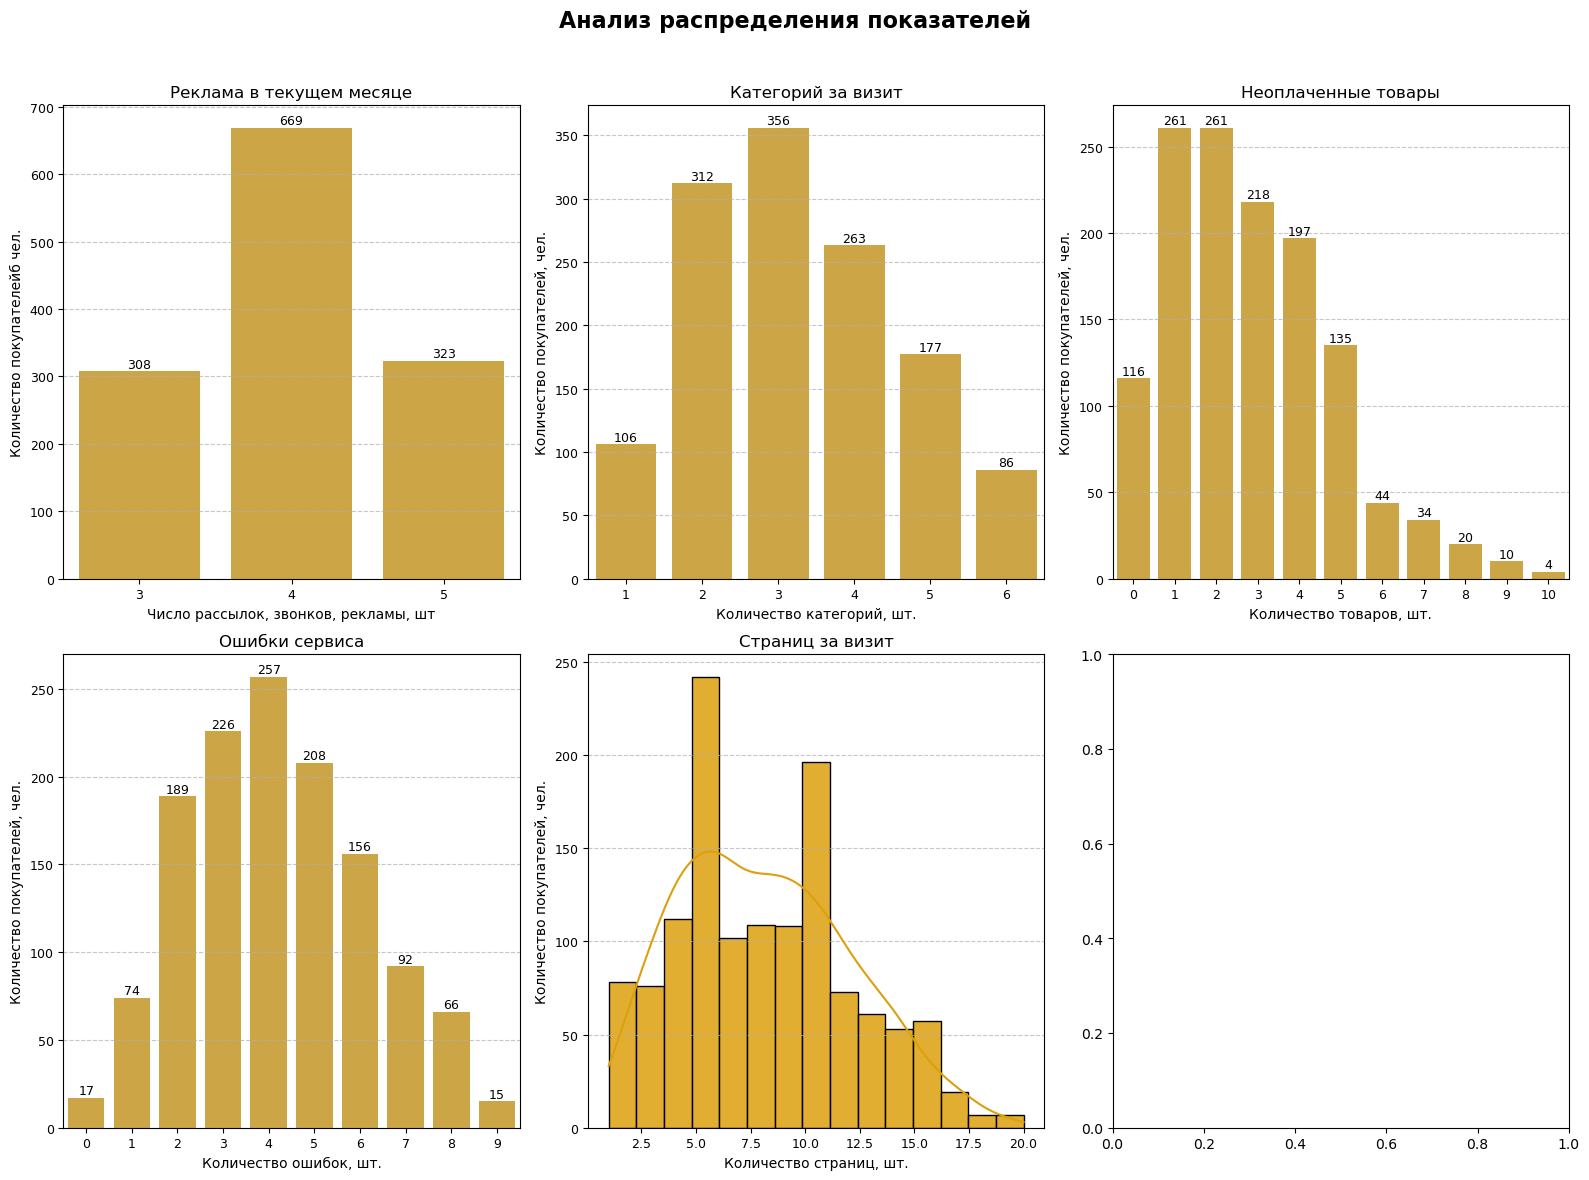


Интерпретация распределений:

• Реклама в текущем месяце:
  - Среднее: 4.01
  - Медиана: 4.00
  - Диапазон: от 3.00 до 5.00
  - Стандартное отклонение: 0.70

• Категорий за визит:
  - Среднее: 3.27
  - Медиана: 3.00
  - Диапазон: от 1.00 до 6.00
  - Стандартное отклонение: 1.36

• Неоплаченные товары:
  - Среднее: 2.84
  - Медиана: 3.00
  - Диапазон: от 0.00 до 10.00
  - Стандартное отклонение: 1.97

• Ошибки сервиса:
  - Среднее: 4.19
  - Медиана: 4.00
  - Диапазон: от 0.00 до 9.00
  - Стандартное отклонение: 1.96

• Страниц за визит:
  - Среднее: 8.18
  - Медиана: 8.00
  - Диапазон: от 1.00 до 20.00
  - Стандартное отклонение: 3.98


In [39]:
# строим графики для дискретных признаков market_file
plot_enhanced(market_file, discrete_cols, labels)

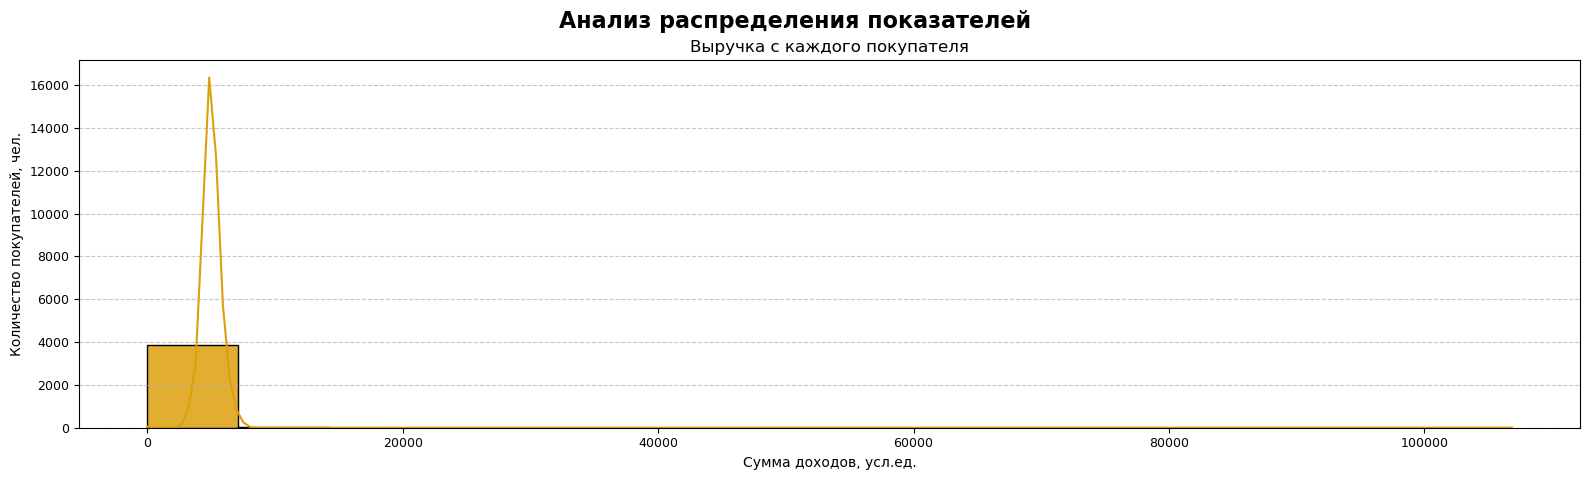


Интерпретация распределений:

• Выручка с каждого покупателя:
  - Среднее: 5025.70
  - Медиана: 4957.50
  - Диапазон: от 0.00 до 106862.20
  - Стандартное отклонение: 1777.70


In [40]:
# строим графики для непрерывного признака Выручка market_money
plot_enhanced(market_money, 
              ['income'], 
              {'income':['Выручка с каждого покупателя', 'Сумма доходов, усл.ед.', 'Количество покупателей, чел.']}
             )

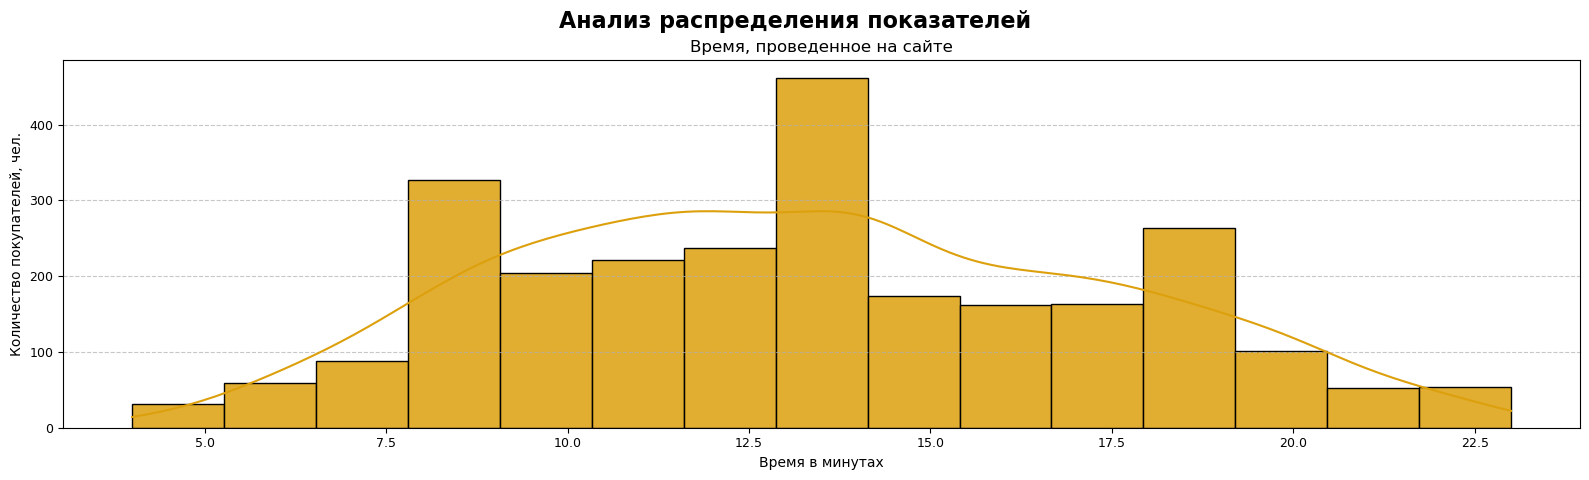


Интерпретация распределений:

• Время, проведенное на сайте:
  - Среднее: 13.34
  - Медиана: 13.00
  - Диапазон: от 4.00 до 23.00
  - Стандартное отклонение: 4.08


In [41]:
# строим график для непрерывного признака  market_time
plot_enhanced(market_time, 
              ['duration_in_mins'], 
              {
    'duration_in_mins': ['Время, проведенное на сайте', 'Время в минутах', 'Количество покупателей, чел.']}
             )

In [42]:
# разделим признаки по типам неприрывные признаки и дискретные в money
continuous_cols_money = ['profit']

# создадим словарь с подписями (название, ось X, ось Y) в market_money
labels_money = {
    'profit': ['Среднемесячная прибыль по каждому покупателю', 'Прибыль, усл.ед.', 'Количество покупателей, чел.']}

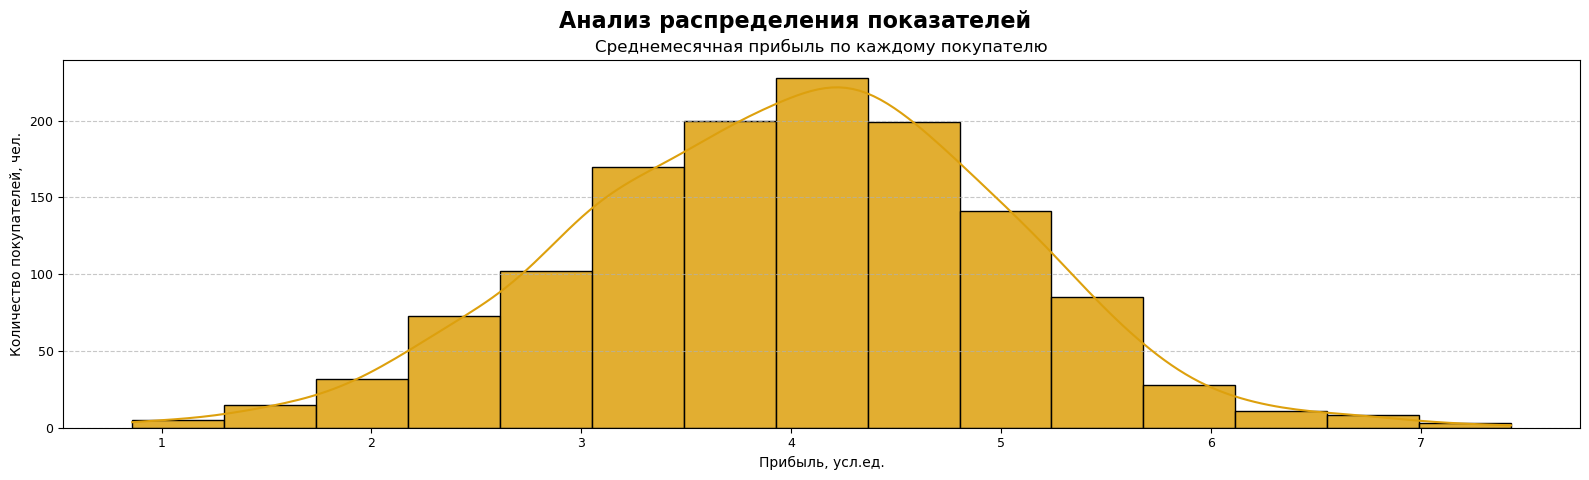


Интерпретация распределений:

• Среднемесячная прибыль по каждому покупателю:
  - Среднее: 4.00
  - Медиана: 4.04
  - Диапазон: от 0.86 до 7.43
  - Стандартное отклонение: 1.01


In [43]:
# строим график для непрерывного признака  money
plot_enhanced(money, 
              ['profit'], 
              {
    'profit': ['Среднемесячная прибыль по каждому покупателю', 'Прибыль, усл.ед.', 'Количество покупателей, чел.']}
             )

**Вывод по распределению количественных показателей в данных интернет-магазина:**

Поведение покупателя на сайте:
* Реклама на покупателя за 6 месяцев: распределение равномерное, мода в значении 4. Диапозон показателя от 0.9 до 6.5. 
* Реклама за покупателя в текущем месяце: распределение стабильное, мода = 4.0.  Диапазон узкий - от 3.0 до 5.0. 
* Длительность регистрации покупателя на сайте: показатель показывает большой разброс, диапозон показателя от 110 до 1100. Чаще всего покупатели имеют регистрацию около 450 дней, что хорошо для постоянных клиентов.
* Доля покупок по акциям: сильная асимметрия с 2 пиками.  Большая часть покупателей покупает по скидкам редко. А правый пик - это сегмент "акционных" покупателей, которые покупают по акции в 90% случаях и выше.
* Количество категорий за визит в последнеий месяц: распределение унимодальное с одним пиком,  мода=3. Чаще покупатели просматривают 3 кагории за визит.
* Число неоплаченных товаров в корзине за последние 3 месяца: заметный разброс - чаще неоплачено от 1 до 4 товаров. 
* Число сбоев у покупателя во время посещения сайта за последние 3 месяца: умеренный разброс. Чаще всего покупатели встречают 4 ошибки.
* Количество страниц за визит за последние 3 месяца:  широкий разброс. Имеется 2 пика - чаще всего за визит смотрят 5.0 или 11.0 страниц. 

Выручка магазина с каждого покупателя:
* Сумма выручки за период в условных единицах: сильная асимметрия распределения данных. Основная масса покупателей приносит выручку чаще всего около 5 тыс.ед. Экстремальный выброс - более 100 тыс.ед. требует проверки на ошибку данных.

Время покупателя на сайте:
* Время покупателя на сайте в минутах: мультимодальное распределение (3 пика), что нормально для поведенческих метрик. Диапазон: От 4 до 23 минут. Наблюдается 3 пика - самые частотные длитености проведения на сайте это 8 минут, 14 минут и 19 минут. 

Прибыль магазина с каждого покупателя за месяц:
* Прибыль с каждого покупателя в усл. ед.: распределение симметричное: среднее=4 и медиана=4 совпадают. Пик=4, то есть чаще всего покупатели генерирует прибыль около 4 усл. ед.

В датафреме `market_money` проанализируем более подробно параметр Выручка магазина с каждого покупателя `income` с помощью ящика с усами чтобы посмотреть среднее, медиана, выбросы.

count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: income, dtype: float64


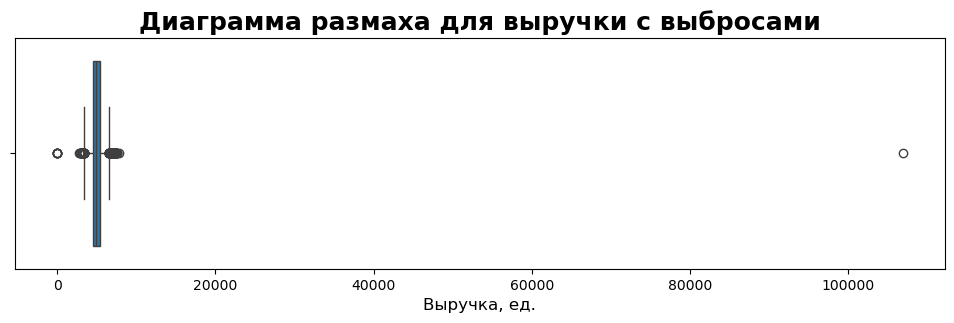

In [44]:
print(market_money['income'].describe())

# построим ящик с усами для признака "выручка", чтобы посмотреть выбросы
plt.figure(figsize=(12, 3))  
ax = sns.boxplot(x=market_money['income'])  
plt.title('Диаграмма размаха для выручки c выбросами', fontsize=18, fontweight='bold')
plt.xlabel('Выручка, ед.', fontsize=12)
plt.show()

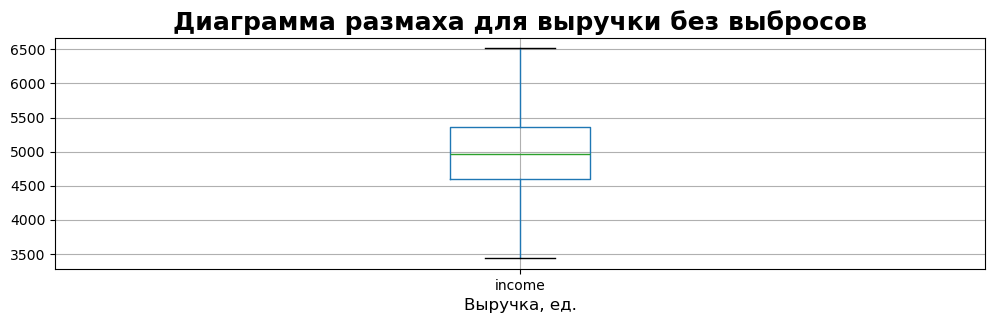

In [45]:
# также построим ящик с усами для признака "выручка" без выбросов
plt.figure(figsize=(12, 3)) 
market_money.boxplot(column='income', showfliers=False)
plt.title('Диаграмма размаха для выручки без выбросов', fontsize=18, fontweight='bold')
plt.xlabel('Выручка, ед.', fontsize=12)
plt.show()

**Вывод по графикам**: на графике Распределения выручки по покупателям четко виден выброс показателей на отметке 106862.2 ед. При том, что среднее значение равно 5025 ед. Половина всех покупателей приносит от 4590 до 4563 ед. При этом медиана очень близка по значению со средним. Стандартное отклонение не больше среднего, что говорит о небольших объемах выбросов. 

#### Категориальные признаки и их графики. 
Рассмотрим и визуализируем категориальные признаки для датафреймов `market_file`, `market_money`, `market_time`:

In [46]:
def pie_chart (df, cols, translation_dict): # создадим функцию  для поcтроения круговой диаграммы      
    for col_names in cols:
        value_counts = df[col_names].value_counts() # получаем столбец по имени и считаем значения
        n_categories = len(value_counts)
        # генерируем параметр количества кусков пирога - сделаем чтобы подстаивался под количество категорий 
        explode = [0.05] * n_categories  # небольшое разделение для всех сегментов
        # Получаем русское название или оставляем оригинальное
        display_name = translation_dict[col_names]
        # строим диаграмму
        plt.figure(figsize=(5,6))
        plt.pie(value_counts.values,
            labels=value_counts.index,    # части пирога назовем данными из колонки сводной таблицы
            autopct='%1.1f%%',            # проценты с одним знаком после запятой
            startangle=90,                # начало отсчета (вершина)
            shadow=True,                  # тень для эффекта объема
            colors=['#E6E6FA','#9370DB'], # цвета для категорий
            explode=explode)              # количество кусков пирога
        plt.title(f"Соотношение показателя {display_name}", fontsize=18, pad=20, fontweight='bold')
        plt.axis('equal')                 # делаем диаграмму круглой
        plt.show()

In [47]:
# отдельно сохраним категориальные показатели для трех датасетов в переменные, тк в дальнейшем переменные нам понадобятся
cat_cols_market_file = market_file.select_dtypes(include=['object']).columns
cat_cols_market_money = market_money.select_dtypes(include=['object']).columns
cat_cols_market_time = market_time.select_dtypes(include=['object']).columns    

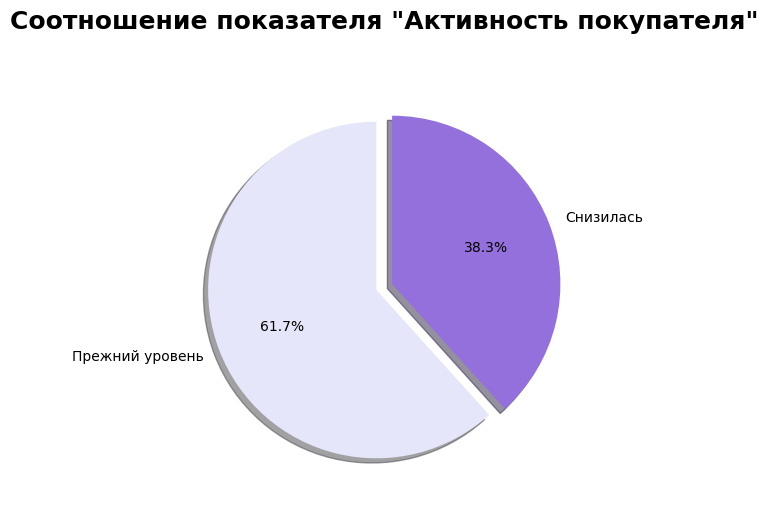

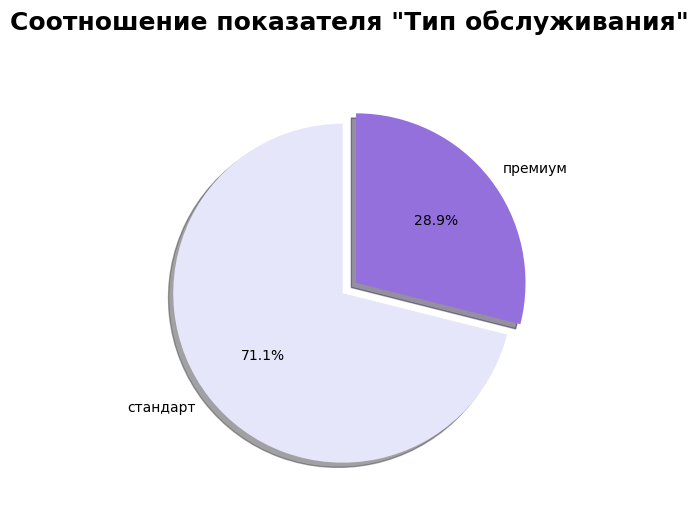

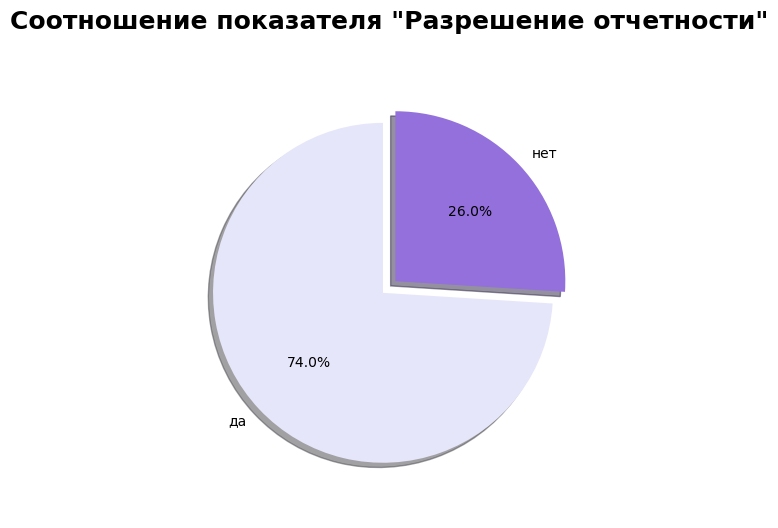

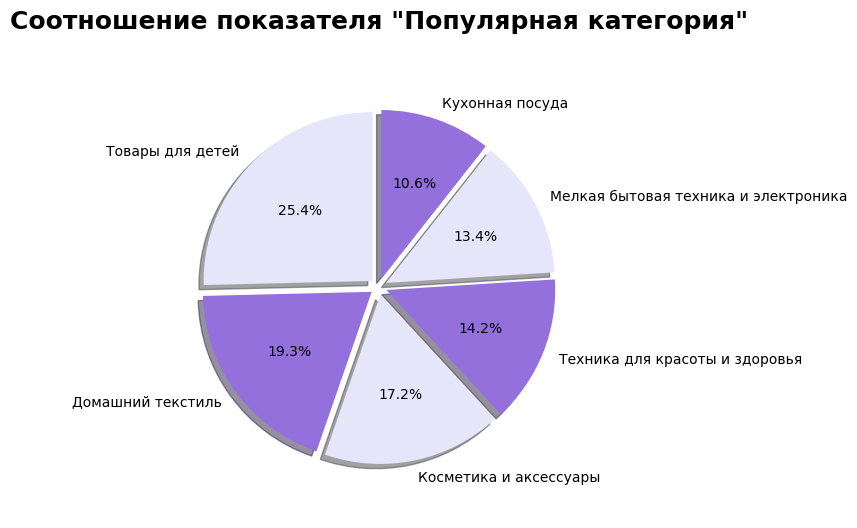

In [48]:
# словарь для перевода английских названий на русский для market_file для более корр.отображения диаграммы 
column_translations = {
    'buyer_activity': '"Активность покупателя"',
    'service_type': '"Тип обслуживания"',
    'allow_reporting': '"Разрешение отчетности"',
    'popular_category': '"Популярная категория"'}

# строим диаграммы для кат.признаков market_file
pie_chart(market_file, cat_cols_market_file, column_translations)

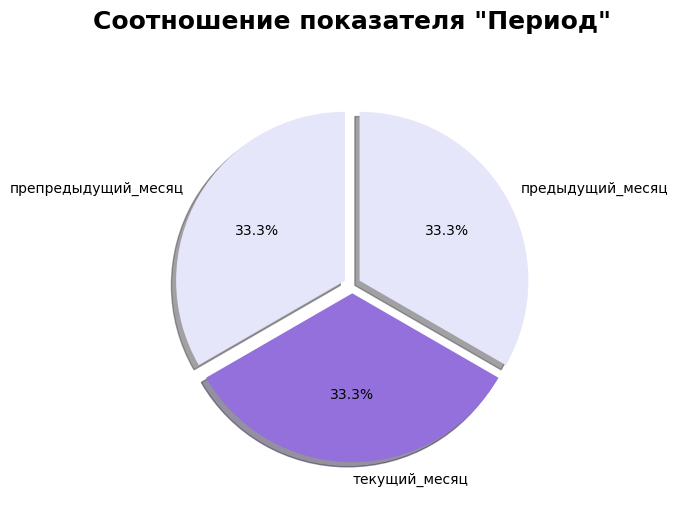

In [49]:
column_translations_2 = {'period': '"Период"'}

# строим диаграммы для кат.признаков датасета market_money
pie_chart(market_money, cat_cols_market_money, column_translations_2)

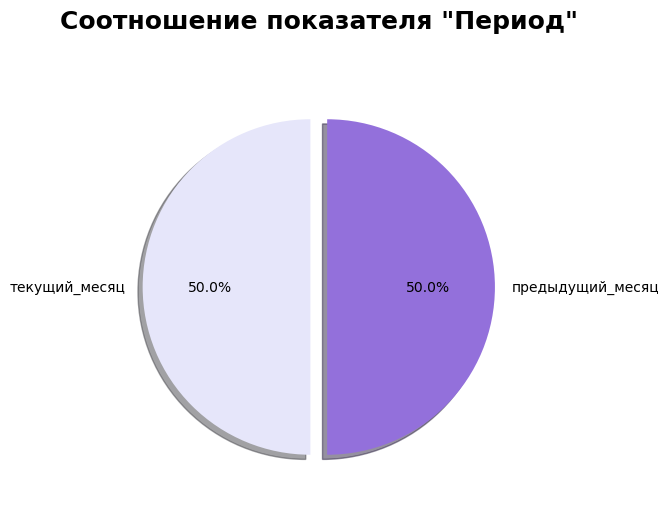

In [50]:
# строим диаграммы для кат.признаков датасета market_time
pie_chart(market_time, cat_cols_market_time, column_translations_2)

**Выводы по анализу категориальных данных датафреймов интернет-магазина:**

1. В датафрейме `market_file` категориальные данные распределены:
* Активность покупателя `buyer_activity`: активность покупателей снизилась  у 38%,а  у 62% покупателей остался Прежний уровень. 
* Тип обслуживания `service_type`: стандартом пользуется 71% покупателей, премиум искользюют 29%. 
* Разрешение отчетности `allow_reporting`: 74% покупателей разрешают присылать им дополнительные предложения о товаре, а 26% - нет.  
* Популярная категория  `popular_category`: Товары для детей лидируют в предпочтениях покупателей (25%). Также популярны Тексиль (19%) и Косметика (17%). Реже покупают товары из категорий: Техника для красоты и здоровья (14%), Мелка бытовая техника (13%) и Кухонная посуда (11%). 
  
2. В датафрейме `market_money` категориальные данные распределены в показателе "Период" равномерно - по 33,(3)% на текущий, предыдущий и предпредыдущий месяца. 
  
3. В датафрейме `market_time` категориальные данные распределены в показателе "Период" одинаково - по 50% на текущий и предыдущий месяца.

### Выводы о данных в исследовательском анализе.

В ходе исследовательского анализа:

1) Был проведен статистический анализ количественных признаков поведения покупателя на сайте, выручки магазина с каждого покупателя, времени покупателя на сайте,  прибыли магазина с каждого покупателя и были выявлено:

*  106862.2 — экстремальный выброс в выручке `profit`, так как возможны ошибки данных или эксклюзивные богатые покупатели. 

2) Построены графики для каждого признака - количественного и категориального и были описаны распределения данных по ним. Выявлены данные на которые следует обратить внимание:
* в количественных параметрах:
  - `promotional_in_purchases` основная масса клиентов покупает редко по скидкам -  менее 30% случаев акций из всех покупок. Выделенный сегмент "акционных" покупателей ведет к риску низкой лояльности.
  -  `unpaid_products_3_months` проблема неоплаченных корзин (4 товара за 3 мес) можно решить оптимизацией процесса оплаты или рассылкой на эти самые товары краткосрочной скидки.
  - `service_error_3_months` технические сбои (в среднем 4 ошибки в 3 мес), возможно, требуется пересмотреть стабильность платформы.
  - `duration_in_mins` три разных пика времени на сайте (8, 14, 19 мин), что говорит о разных типах пользовательского поведения.
* в категориальных параметрах:
  - `buyer_activity` больше трети покупателей (38%) снизила активность, значит, требуется анализ причин спада и разработка стратегии возврата клиентов.
  - `service_type` преобладание пользователей "стандарт" (71%), значит, есть потенциал для увеличения премиум-сегмента покупателей. 

3) Разработан План по улучшению имеющихся данных: 
* потребуется замена выбросов выручки пограничным значением (или медианным).
* исследование причин снижения активности 38% пользователей.
  
4) Разработан План по улучшению данных в следующих периодах:
* устранение ошибок на сайте  - среднее 4 сбоя на покупателя.
* упрощение процесса оплаты, чтобы снизить число неоплаченных товаров. 
* стимулирование перехода с "стандартного" на "премиум" сервис.
  
Рекомендации для дальнейшего анализа - корреляционный анализ между:
* временем на сайте и конверсией в покупку
* количеством ошибок и отказом от покупки
* активностью и прибыльностью пользователей и др. показателей.

## Объединение таблиц

Объединим таблицы `market_file`, `market_money`, `market_time` и создадим новые колонки для отражения периодов выручки и периодов времени на сайте отдельно. 

Сначала проверим количество строк полученной таблицы, и посде объединия сравним их с количеством строк таблиц до объединения. 

In [51]:
# проверим длины датафреймов до объединения
print(f"Длина датафрема 'market_file': {len(market_file)} строк(и), " 
      f"'market_money': {len(market_money)} строк(и), "
      f"'market_time': {len(market_time)} строк(и).") 

Длина датафрема 'market_file': 1300 строк(и), 'market_money': 3900 строк(и), 'market_time': 2600 строк(и).


Также перед итоговым объединением таблиц реализуем план по улучшению данных: заменим аномальные значения (выбросы) в параметре "Выручка" на медианные:

In [52]:
# заменяем выбросы в столбце выручки
market_money.loc[market_money['income'] > 10000, 'income'] = market_money['income'].median()
market_money['income'].describe()

count    3900.000000
mean     4999.566641
std       706.909531
min         0.000000
25%      4590.150000
50%      4957.250000
75%      5363.000000
max      7799.400000
Name: income, dtype: float64

Перед объединением датасетов добавим новые колонки в датасеты `market_money`, `market_time`, создав отдельную колонку для каждого типа периода:
* `income_current` - выручка за текущий месяц
* `income_previous` - выручка за предыдущий месяц
* `income_preprevious` - выручка за предпредыдущий месяц
* `time_current` - время на сайте за текущий месяц
* `time_previous` - время на сайте за предыдущий месяц

In [53]:
# создадим сводную таблицу по 3 периодам с выручкой
market_money_pivot = market_money.pivot(
            index='client_id', 
            columns='period', 
            values='income'
        ).reset_index()

# переименовываем колонки сводной таблицы с выручкой
market_money_pivot.columns = ['client_id', 
                              'income_preprevious',  # предпредыдущий мес.
                              'income_previous',     # предыдущий мес.
                              'income_current']      # текущий мес.

# создадим сводную таблицу по 2 периодам с временем на сайте
market_time_pivot = market_time.pivot(
        index='client_id', 
        columns='period', 
        values='duration_in_mins'
    ).reset_index()

# переименовываем колонки сводной таблицы для времени
market_time_pivot.columns = ['client_id', 
                             'time_current',   # текущий мес.
                             'time_previous']  # предыдущий мес.

Объединяем датасеты `market_file`, `market_money`, `market_time`. 

Для объединения используем метод `merge()` и параметр `left` для того, чтобы сохранить все записи в 3 датафреймах, а колонки `client_id` из всех таблиц будут объединены в одну.

In [54]:
merged_df = (market_file.merge(market_money_pivot, on='client_id', how='left'
                             ).merge(market_time_pivot, on='client_id', how='left'))

merged_df.head()

,client_id,buyer_activity,service_type,allow_reporting,ads_6_months,ads_this_month,duration,promotional_in_purchases,popular_category,avg_category_per_visit,unpaid_products_3_months,service_error_3_months,pages_per_visit,income_preprevious,income_previous,income_current,time_current,time_previous
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,0.0,0.0,3293.1,13,14
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11


In [55]:
# проверим появились ли после объединения пропуски 
display(
    isna_table(merged_df).set_caption("Данные интернет-магазина")) 

len(merged_df) # проверим длину нового датасета после объединения

,0
client_id,0.000000
buyer_activity,0.000000
service_type,0.000000
allow_reporting,0.000000
ads_6_months,0.000000
ads_this_month,0.000000
duration,0.000000
promotional_in_purchases,0.000000
popular_category,0.000000
avg_category_per_visit,0.000000


1300

Однако, в датафрейме с первых строк были обнаружены значения 0.0 типа float, который при математических операциях могут выбать ошибку (например деление на 0), поэтому вручную поищем такие нулевые значения:

In [56]:
# столбцы для проверки нулей
columns = [
    'income_preprevious', 
    'income_previous', 
    'income_current']

# находим строки с нулями в этих столбцах
zero_mask = (merged_df[columns] == 0).any(axis=1)
print(f"Найдено строк с проблемными нулями: {zero_mask.sum()}")

Найдено строк с проблемными нулями: 3


In [57]:
# удаляем строки, где есть нули в critical_columns
merged_df = merged_df[~zero_mask]
len(merged_df)

1297

**Вывод по этапу "Объединение таблиц":**  

Объединение данных о поведении покупателя на сайте, выручке и времени, проведенном на сайте, в один датафрейм `merged_df` произведенен успешно. Был использован метод `merge()` и параметр `left`. Сохранены все записи из главного датафрейма `market_file` в 1300 строк. Было найдено строк с проблемными нулями и удалено: 3 строки. Всего записей в новом датафрейме  также 1297 строк. Информация из датафреймов о выручке клиентов `market_money_pivot` и времени на сайте `market_time_pivot` подвязались к каждой строке к соответсвующему пользователю в `market_file`.

##  Корреляционный анализ

### Взаимосвязь между признаками: рассчет коэффициентов корреляции между всеми признаками.

Проведем корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования. Выявим и устраним при необходимости возможные инциденты по мультиколлинеарности.

Для корректного расчета корреляций необходимо преобразовать категориальные переменные в числовой формат с помощью `One-Hot Encoding`:

In [58]:
merged_df.head()

,client_id,buyer_activity,service_type,allow_reporting,ads_6_months,ads_this_month,duration,promotional_in_purchases,popular_category,avg_category_per_visit,unpaid_products_3_months,service_error_3_months,pages_per_visit,income_preprevious,income_previous,income_current,time_current,time_previous
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
5,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


In [59]:
# определение непрерывных признаков 
interval_cols = ['ads_6_months', 
                 'duration', 
                 'promotional_in_purchases', 
                 'duration_in_mins', 
                 'income_preprevious', 
                 'income_previous', 
                 'income_current']

# cоздаем копию объединненого датасета без столбца 'client_id'
corr_df = merged_df.drop(columns=['client_id'], errors='ignore')

Рассчитаем `матрицу корреляций phik` для признаков объединенной `merged_df`:

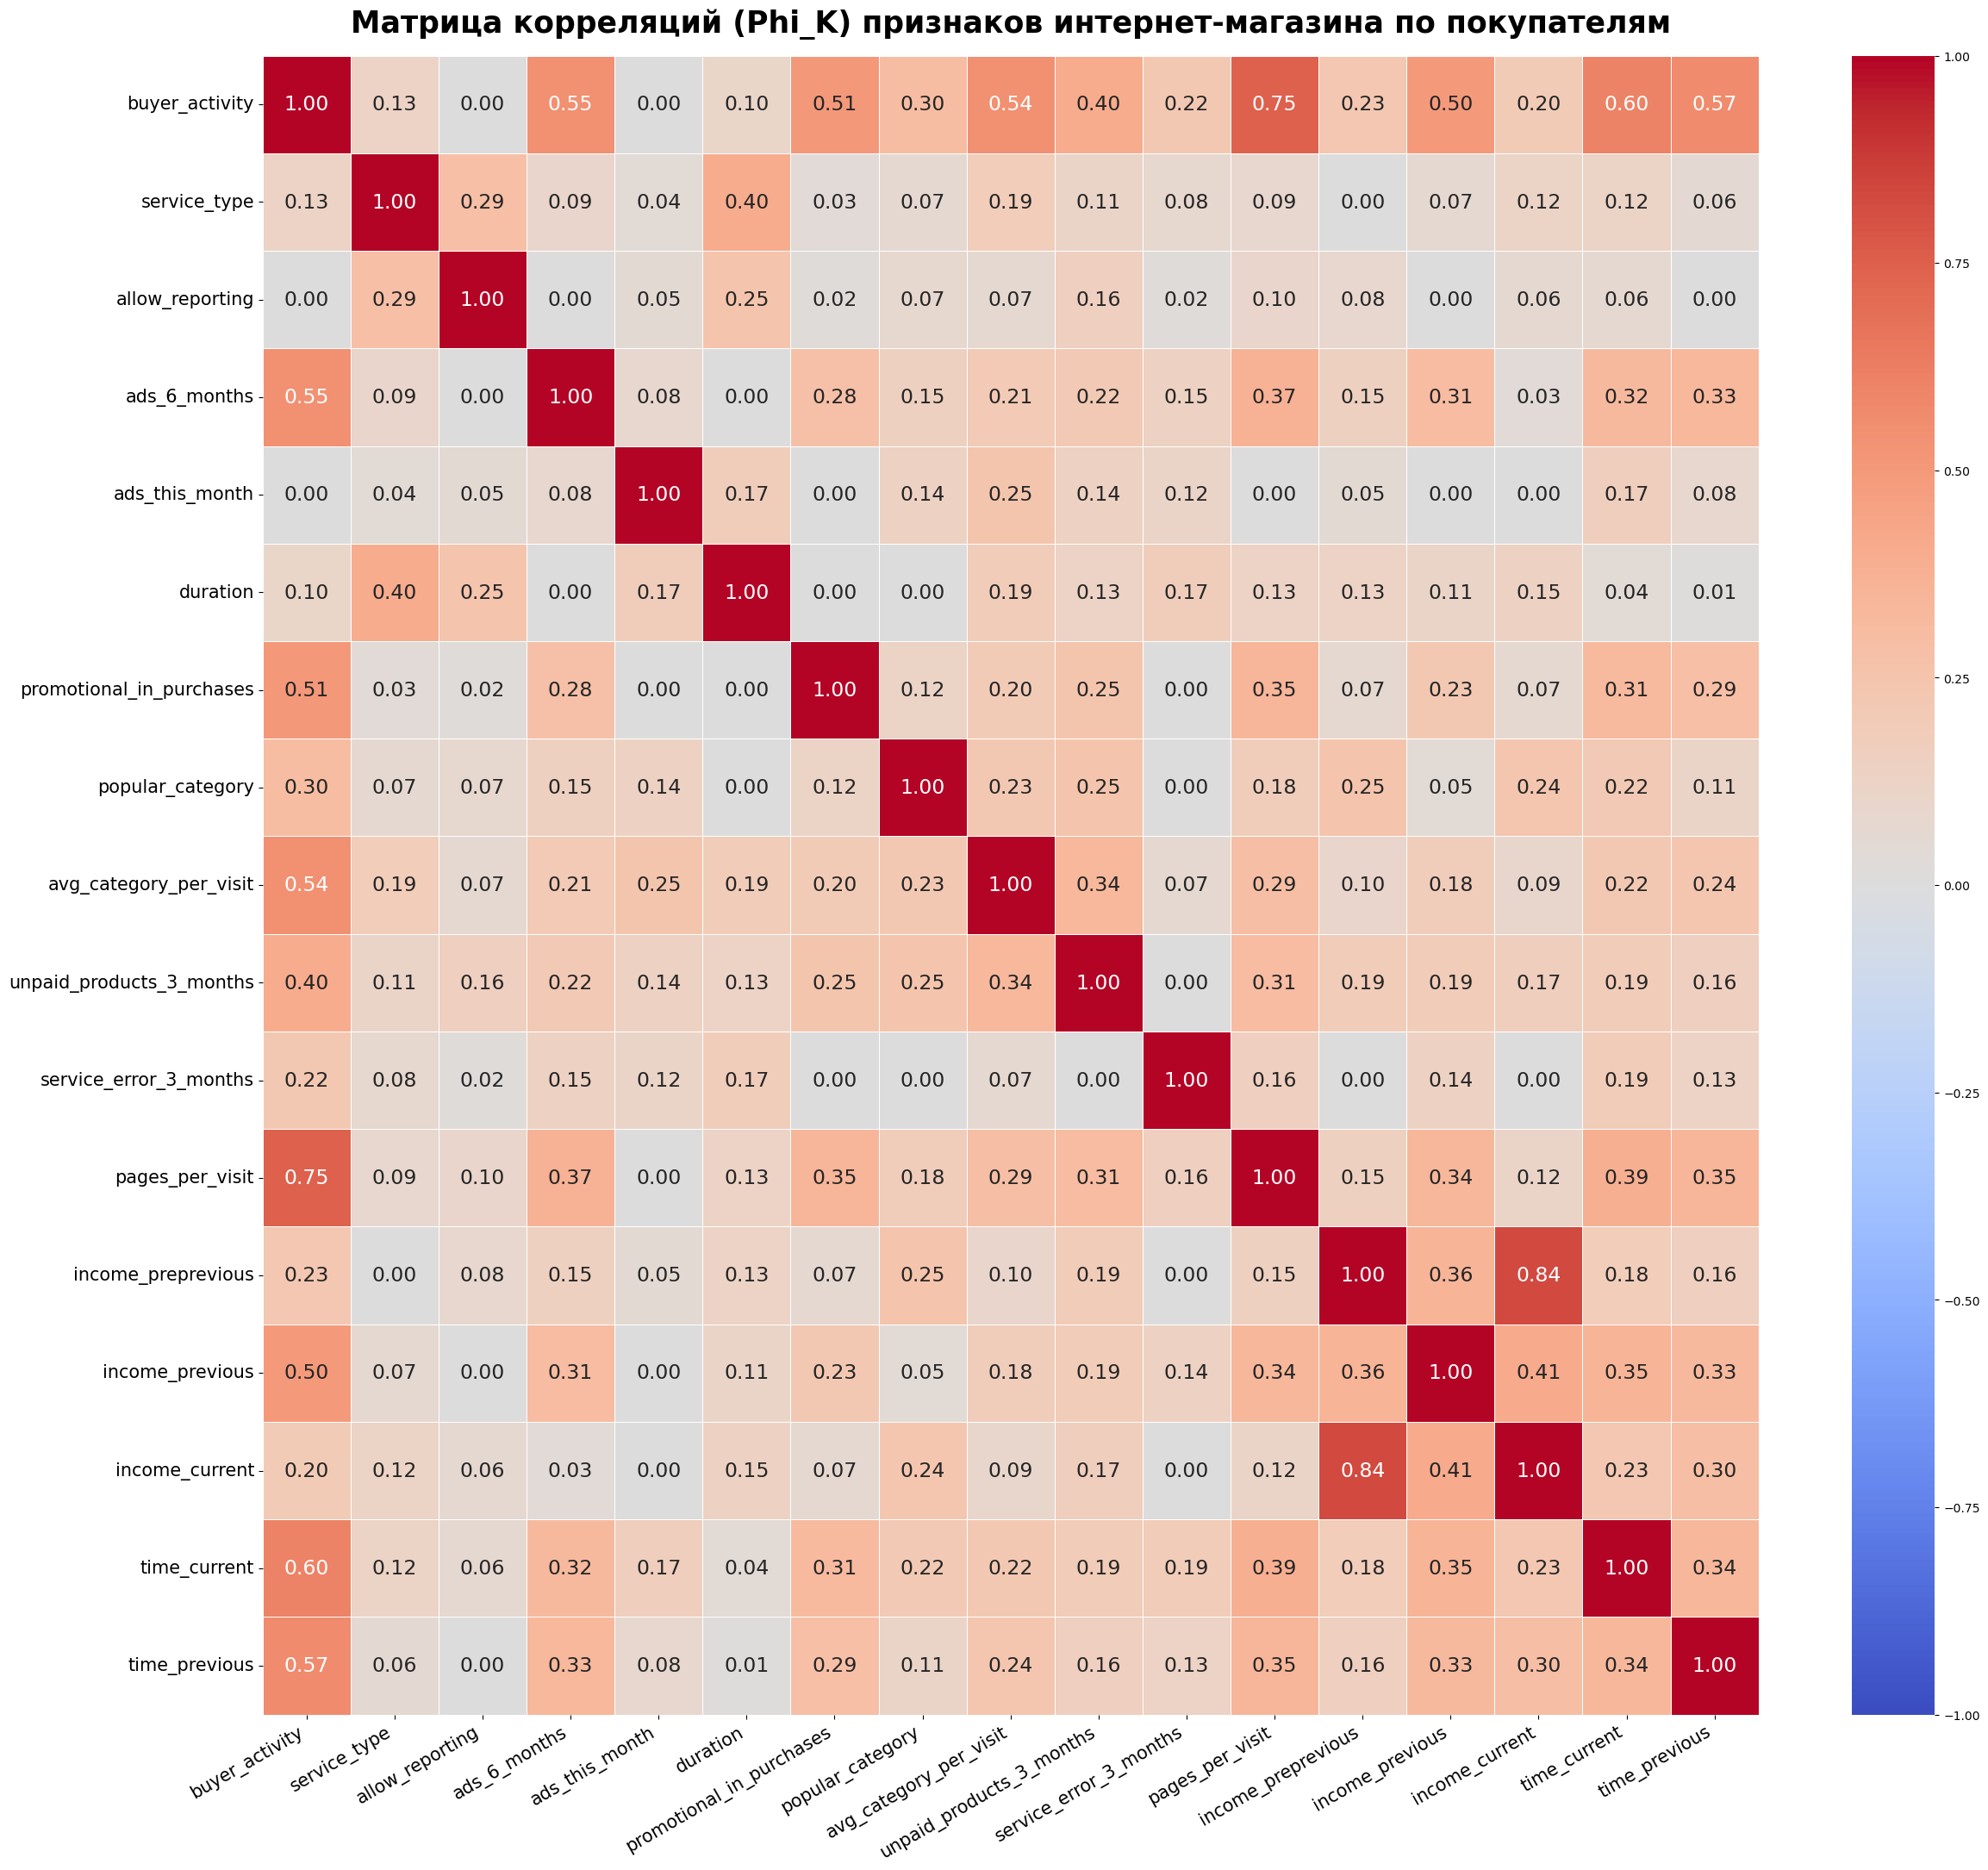

In [60]:
corr_matrix = corr_df.phik_matrix(interval_cols=interval_cols)

# визуализация матрицы корреляций
plt.figure(figsize=(28, 25))
sns.heatmap(corr_matrix, 
            annot=True, 
            fmt=".2f",
            cmap="coolwarm",
            vmin=-1, 
            vmax=1,
            annot_kws={"size": 17},
            linewidths=0.5
           )
plt.title("Матрица корреляций (Phi_K) признаков интернет-магазина по покупателям", 
          fontsize=25, pad=20, fontweight='bold')

plt.xticks(rotation=30, ha='right', fontsize=15)
plt.yticks(rotation=0, fontsize=15)
plt.show()

### Выводы о взаимосвязи признаков по матрице корреляций:

1. Сильные корреляции:
* выручка текущего месяца и выручка предпредыдущего месяца:  0.83. Самая сильная связь в датасете, то есть с высокая выручка за предпредыдущий месяц с большой долей вероятности имеет и высокую вырочку в текущем месяцу по покупателю, и наоборот. 
* покупательская активность и показатель просмотренных страниц за визит: 0.75. Сильная связь, при том, что 1 - это снижение ативности, а 0 - прежний уровень. Это говорит о том, что чем больше покупатели просматривают страниц за визит, тем больше вероятность, что они ничего не купят. 

2. Умеренные корреляции:
* время на сайте за текущий месяц и снижение покупательской активности: 0.60. Также довольно значимая зависимость. Это говорит о том, что если повышется время проведенное на сайте в текущем месяце, то снижается  покупательская активность.
* время на сайте за прошлый месяц и снижение покупательской активности: 0.57. Умеренная зависимость. Это говорит о том, что если повышается время проведенное на сайте в прошлом месяце, то вероятно снизится покупательская активность покупателя.
* реклама за 6 месяцев и снижение покупательской активности: 0.55. Умеренная зависимость. Значит, при увеличении трафика ракламы на покупателя снижается покупательская активность покупателя. 
* средний просмотр категорий за визит и снижение покупательской активности покупателя:  0.54. Умеренная  зависимость. То есть, чем меньше просмотров категорий за визит, тем больше снижается покупательская активность покупателя.
* доля акционных товаров в покупках  и снижение покупательноской активности: 0.51. Выходит, что лояльность "акционщиков" снижается.
* неоплаченные продукты за 3 месяца и снижение покупательской активности: 0.40. Наблюдается умеренно-слабая корреляция между неоплаченными товарами в корзине и снижением покупательской активности. Возможно, покупатель испытал ошибки при покупке товаров и после этого перестал пользоваться сервисом. Данная гипотеза требует дополнительных исследований.
* количество посещенных страниц за визит и время на сайте за текущий месяц: 0.39. Логично, что чем больше времени уходит на сайт при визите, тем возможно больше удается просмотреть страниц.
* количество посещенных страниц за визит и реклама за 6 месяцев: 0.37. Наблюдается умеренно-слабая корреляци между количеством посещенных страниц за визит и рекламой за 6 месяцев, значит, зачастую реклама справляется с тем, чтобы доносить по покупатлей информацию о своих продуктах. 
* выручка предыдущего месяца и выручка предпредыдущего месяца:  0.35. То есть выручка за предпредыдущий месяц умеренно коррелирует  с вырочкой за предыдущий месяц по покупателю.
* доля акционных товаров в покупках  и количество просматриваемых страниц за визит: 0.35. Получается, что чем меньше страниц покупатель смотрит за визит, тем больше покупает акционных товар. Значит, скорее всего "акционщики" не ищут долго нужный товар, а сразу покупают то, что предлагают только по акции.

Остальные связи выглядят очень слабыми.

Ключевые показатели в зависимостях, которые необходимо учитывать в моделировании: 
* параметр "выручка предыдущего месяца", влияющий на предсказание выручки текущего месяца.
* параметр "показатель просмотренных страниц", который прямо указывает на снижение покупательской активности.
* параметр "доля акционных товаров в покупках", который указывает линейно и прямо на снижение покупательской активности.
* параметр "выручка предпредыдущего месяца", влияющий на выручку предыдущего года.
* параметры:  "количество посещенных страниц за визит", "время на сайте за текущий месяц", "время на сайте за прошлый месяц", "реклама за 6 месяцев", "Средний просмотр категорий за визит",  снижение которых явно отражают снижение покупательской активности.

Мультиколлинеарность между признаками: в данных имеются сильные связи между признаками (особенно признаки выручки), но все они по модулю менее коэффициента 0.9  и не должны создавать мультиколлинеарность между признаками, однако, для линейных моделей (логистическая регрессия) корреляция 0.8 может быть проблематичной. Поэтому также воспользуемся методом  VIF (Variance Inflation Factor) для проверки  мультиколлинеарности. 

In [61]:
# рассчитаем VIF для признаков в датасете и создадим функцию
def vif_corr (df, cols):
    vif_data = pd.DataFrame()
    vif_data["feature"] = cols
    vif_data["VIF"] = [
        variance_inflation_factor(df[cols].values, i) 
        for i in range(len(cols))]

    return vif_data.sort_values("VIF", ascending=False)

In [62]:
# добавим константу в датафрейм тк без константы вспомогательные регрессии будут некорректными, что исказит значения VIF
df_with_const = add_constant(merged_df)
# выберем только числовые признаки
num_features = df_with_const.select_dtypes(include=['number']).columns
# рассчитаем VIF для каждого признака
vif_corr(df_with_const, num_features)

,feature,VIF
0,const,591513.372106
10,income_preprevious,4.262381
12,income_current,3.881029
1,client_id,1.795869
11,income_previous,1.631381
13,time_current,1.594068
9,pages_per_visit,1.520324
14,time_previous,1.387661
2,ads_6_months,1.242585
7,unpaid_products_3_months,1.216464


**Анализ VIF  результатов**

Константа (const): VIF = 591231.88  константа всегда имеет бесконечный VIF,  он не информативен

Проблемные признаки дохода :
* `income_preprevious`: VIF = 4.26 
* `income_current`: VIF = 3.88
* `income_previous` :  VIF = 1.63

VIF < 5 - это умеренная мультиколлинеарность, что допустимо, но необходимо проверить отдельно корреляцию между этими признаками. Это модет означать, что доходы за разные периоды коррелируют между собой, и модель может испытывать трудности с разделением их индивидуального влияния.

Все остальные признаки имеют VIF < 2, что говорит об отсутсвии мультиколлинеарности.

In [63]:
# проверим отдлеьно еще раз корреляцию доходов
income_features = ['income_preprevious', 'income_previous', 'income_current']
print(merged_df[income_features].corr())

                    income_preprevious  income_previous  income_current
income_preprevious            1.000000         0.328247        0.837813
income_previous               0.328247         1.000000        0.121486
income_current                0.837813         0.121486        1.000000


**Выводы из корреляционной матрицы по доходам:**
    
* Сильная связь текущего и позапрошлого дохода: корреляция между `income_current` и `income_preprevious` = 0.84 (объясняет высокий VIF у этих признаков - 4.26 и 3.88)
* Слабая связь текущего и прошлого дохода: корреляция `income_current` и `income_previous` = 0.12 (отсутствует линейная зависимость),
* Умеренная связь прошлого и позапрошлого дохода: корреляция `income_previous` и `income_preprevious` = 0.32 (умеренная связь).

Решение проблемы:
1. Удалить данные о доходе за позапрошлый месяц: так как они дублируют данный за текущий доход (корреляция 0.84).
2. Создать новый признак "изменение дохода" из разницы `income_current` и `income_previous`. Это заменит оба признака одной информативной метрикой. 

In [64]:
# преобразование показателей income_previous и income_current в один признак "изменение дохода"
merged_df['income_change'] = (
    (merged_df['income_current'] - merged_df['income_previous']) / merged_df['income_previous'])

# удаляем коррелирующий признак income_preprevious и преобразованные - income_previous и income_current
merged_df = merged_df.drop(columns=[
    'income_current',
    'income_previous', 
    'income_preprevious'
])
merged_df['income_change'].isna().sum() # также проверим пропуски в новом признаке 

0

**Вывод по этапу "Корреляционный анализ":**

На этапе корреляционный анализа: 

1. была построена матрица корреляций и опеределены: сильные, умеренные и слабые  положительные и отрицательные связи.
2. был рассчитан VIF для признаков в датасете и определены связи, требующие внимания (VIF близкий к 5):
    Проблемные признаки дохода :
   -  `income_preprevious`: VIF = 4.26 
   -  `income_current`: VIF = 3.88
   -  `income_previous` :  VIF = 1.63
3. были преобразованы показатели по выручке в один: `income_change`
4. были удалены коррелирующий признак  - `income_preprevious`, и  преобразованные признаки - `income_previous`, `income_current`.

## Создание пайплайнов

### Создание пайплайна для подготовки данных.

Во время подготовки данных используем `ColumnTransformer()`. Количественные и категориальные признаки обработаем в пайплайне раздельно. 

In [65]:
# разделим признаки на входные и целевой
X = merged_df.drop(columns=['buyer_activity', 'client_id'])
y = merged_df['buyer_activity']

# сначала разделяем, потом сэмплируем только тренировочные данные
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y
)
# оцениваем процент объектов каждого класса целевого признака 
y_train.value_counts(normalize=True)

buyer_activity
Прежний уровень    0.618313
Снизилась          0.381687
Name: proportion, dtype: float64

Сэмплируем данные с помощью RandomOverSampler, чтобы уравновесить доли категорий целевого признака: 

In [66]:
# оверсемплируем с помощью RandomOverSampler (увеличим меньший класс до большего)
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=RANDOM_STATE)

X_train_res, y_train_res = oversampler.fit_resample(X_train, y_train)

In [67]:
# проверяем баланс классов ПОСЛЕ сэмплирования
y_train_res.value_counts(normalize=True)

buyer_activity
Прежний уровень    0.5
Снизилась          0.5
Name: proportion, dtype: float64

In [68]:
# признаки для OneHotEncoder (номинальные)
ohe_columns = ['popular_category', 
               'allow_reporting'] 

# признаки для OrdinalEncoder (порядковые)
ord_columns = ['service_type']  

# признаки для масштабирования
num_columns = ['ads_6_months', 
               'ads_this_month' , 
               'duration', 
               'promotional_in_purchases', 
               'avg_category_per_visit', 
               'unpaid_products_3_months', 
               'service_error_3_months', 
               'pages_per_visit', 
               'time_previous', 
               'time_current', 
               'income_change']

In [69]:
# подготовим признаки для OrdinalEncoder 
merged_df['service_type'].unique()

array(['премиум', 'стандарт'], dtype=object)

In [70]:
# SimpleImputer + OHE 
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe',
            OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        )
    ]
)
# SimpleImputer + ORD +  SimpleImputer
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord', 
            OrdinalEncoder(
                categories=[
                    ['премиум', 'стандарт'],
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan)
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)
# объединение шагов подготовки 
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='drop'
)

### Обучение моделей и подбор гиперпараметров

Обучим четыре модели: `KNeighborsClassifier()`, `DecisionTreeClassifier()`, `LogisticRegression()` и  `SVC()` и подберем гиперпараметры: * комбинацию модели и гиперпараметров - в словарь `param_grid` добавим модели: DecisionTreeClassifier(), SVС(), KNeighborsClassifier() и LogisticRegression() и для каждой модели также определим словарь дополнительных гиперпараметров отдельно.

Для автоматического подбора модели и гиперпараметров будем использовать один общий пайплайн и инструмент `RandomizedSearchCV()`, так как данный инструмент эффективен, так как сокращает количество проверок и охватывает достаточное количество комбинаций гиперпараметров за сравнительно короткое время. 

Метрика ROC-AUC - площадь под ROC-кривой -  оценивает качества моделей по всем возможным порогам (то есть нет зависит от порога, как F1 мера, Precision или Recall) - по этой причине мы будем ее использовать для оценки при подборе гиперпараметров.

In [71]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final= Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

In [72]:
# зададим гиперпараметры для моделей
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 100), 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': [0.01, 0.1, 1.0, 10.0, 100.0],  # ИЗМЕНЕНО было [0.1, 1.0, 10.0, 100.0]
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
     # ДОБАВЛЕНО :словарь для модели RandomForestClassifier()
    {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'models_n_estimators': [50, 100, 200],
        'models_max_depth': [3, 5, 7],
        'preprocessor_num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [73]:
# перебор гиперпараметров методом RandomizedSearchCV
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
# запуск пайплайна
randomized_search.fit(X_train_res, y_train_res)

,estimator,Pipeline(step...m_state=42))])
,param_distributions,"[{'models': [DecisionTreeC...ndom_state=42)], 'models__max_depth': range(2, 5), 'models__max_features': range(2, 5), 'preprocessor__num': [StandardScaler(), MinMaxScaler(), ...]}, {'models': [KNeighborsClassifier()], 'models__n_neighbors': range(2, 100), 'preprocessor__num': [StandardScaler(), MinMaxScaler(), ...]}, ...]"
,n_iter,10
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [74]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Результат на кросс-валидации:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['popular_category',
                                                   'allow_reporting']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_freq

Проверка работы модели на тестовой выборке:

In [75]:
# рассчет прогноз на тестовых данных
y_pred = randomized_search.predict_proba(X_test)[:, 1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_pred)}')

Метрика ROC-AUC на тестовой выборке: 0.8688813994543413


In [76]:
# создадим список с параметрами моделей
results_df = pd.DataFrame(randomized_search.cv_results_).sort_values(by='split0_test_score', ascending=False)
results_df.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__n_neighbors,param_models,param_models__max_features,param_models__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.007368,0.002709,0.021968,0.008232,StandardScaler(),4.0,KNeighborsClassifier(),NaN,NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.920902,0.897211,0.877257,0.935799,0.951667,0.916567,0.026610,1
4,0.008124,0.002955,0.003638,0.000498,StandardScaler(),12.0,KNeighborsClassifier(),NaN,NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.911570,0.914669,0.894687,0.933160,0.924375,0.915692,0.012959,2
5,0.007944,0.002260,0.006489,0.002150,StandardScaler(),54.0,KNeighborsClassifier(),NaN,NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.896556,0.925620,0.893576,0.915625,0.942083,0.914692,0.018140,3
9,0.011372,0.007342,0.004431,0.000731,StandardScaler(),35.0,KNeighborsClassifier(),NaN,NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.896143,0.929752,0.885278,0.916146,0.942257,0.913915,0.020952,4
3,0.011058,0.001244,0.007411,0.001844,MinMaxScaler(),96.0,KNeighborsClassifier(),NaN,NaN,"{'preprocessor__num': MinMaxScaler(), 'models_...",0.841839,0.864256,0.816042,0.861285,0.866181,0.849920,0.019038,6
0,0.010646,0.003178,0.026615,0.005478,MinMaxScaler(),57.0,KNeighborsClassifier(),NaN,NaN,"{'preprocessor__num': MinMaxScaler(), 'models_...",0.838981,0.852101,0.818611,0.831250,0.847569,0.837702,0.011937,7
6,0.006877,0.002278,0.003679,0.000198,MinMaxScaler(),18.0,KNeighborsClassifier(),NaN,NaN,"{'preprocessor__num': MinMaxScaler(), 'models_...",0.838671,0.896109,0.837361,0.859063,0.894722,0.865185,0.025859,5
2,0.009999,0.002681,0.003138,0.001381,StandardScaler(),NaN,DecisionTreeClassifier(random_state=42),4.0,3.0,"{'preprocessor__num': StandardScaler(), 'model...",0.779718,0.820317,0.808958,0.793229,0.805833,0.801611,0.013938,8
7,0.007644,0.003068,0.004248,0.000569,passthrough,32.0,KNeighborsClassifier(),NaN,NaN,"{'preprocessor__num': 'passthrough', 'models__...",0.649518,0.673416,0.674028,0.762708,0.691597,0.690253,0.038620,9
8,0.006398,0.002438,0.004279,0.000694,passthrough,43.0,KNeighborsClassifier(),NaN,NaN,"{'preprocessor__num': 'passthrough', 'models__...",0.617906,0.646591,0.616250,0.718299,0.620868,0.643983,0.038763,10


**Вывод:** лучшей себя показала модель `KNeighborsClassifier` (метрика на кросс-валидации: 0.916) с параметрами (n_neighbors=17) и  с методом масштабирования `StandardScaler()`. Метрика ROC-AUC на тестовой выборке: 0.909.


Рассчитаем также  метрику F1-score для комплексной оценки модели:

In [93]:
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1-score: {f1:.3f}")

F1-score: 0.840


**Вывод по этапу "Создание пайплайнов":**

В ходе этапа создания пайплайнов была проведена следующая работа: 
* написан пайплайн обработки данных 
* обучены четыре модели и выбрана лучшая модель по метрике
* для оценки качества модели была выбрана метрика `ROC-AUC` и данное выбор был обоснован.

Итог работы этапа: наилучшей себя показала модель `KNeighborsClassifier`  (метрика на кросс-валидации: 0.916)  с параметром `n_neighbors`= 17 и с методом масштабирования `StandardScaler()`. Метрика `ROC-AUC` на тестовой выборке: 0.909.

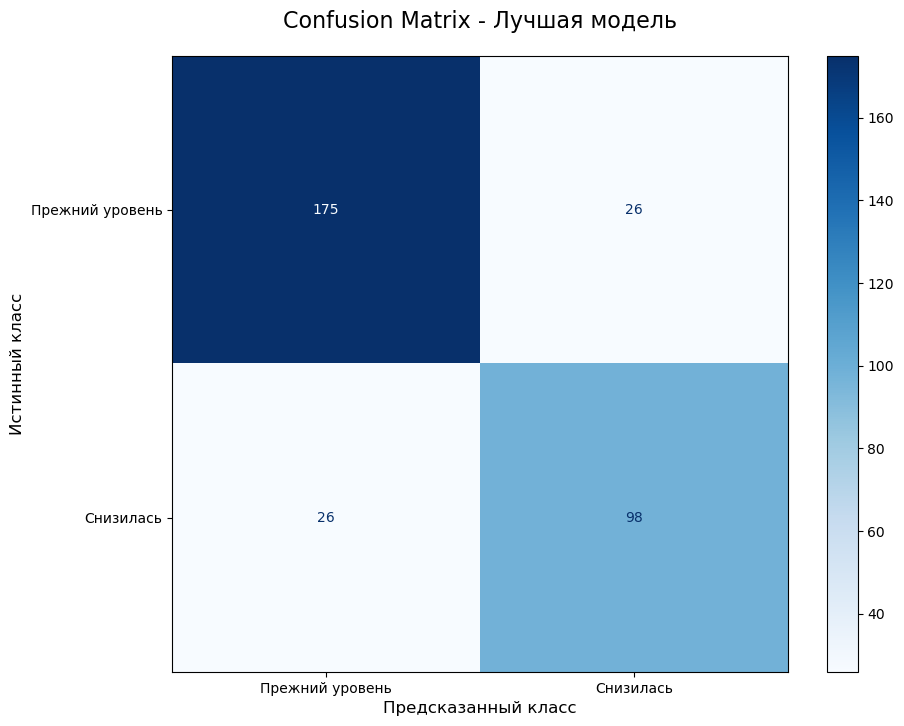

Подробный отчет о классификации:
                 precision    recall  f1-score   support

Прежний уровень       0.87      0.87      0.87       201
      Снизилась       0.79      0.79      0.79       124

       accuracy                           0.84       325
      macro avg       0.83      0.83      0.83       325
   weighted avg       0.84      0.84      0.84       325



In [77]:
best_model = randomized_search.best_estimator_
# делаем предсказания на тестовых данных
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # вероятности для ROC AUC

# строим Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)

# визуализируем матрицу ошибок
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Лучшая модель', fontsize=16, pad=20)
plt.xlabel('Предсказанный класс', fontsize=12)
plt.ylabel('Истинный класс', fontsize=12)
plt.show()

# отчет о классификации
print("Подробный отчет о классификации:")
print(classification_report(y_test, y_pred, target_names=best_model.classes_))

**Вывод по матрице ошибок:**

* Precision для "Снизилась"=0.86: модель предсказывает снижение, она права в 86% случаев
* Recall для "Снизилась"=0.82: модель находит 82% реальных случаев снижения активности.
* FN ошибки: 22 реальных "Снизилась" ошибочно классифицированы как "Прежний уровень"
* F1-score"Снизилась"=0.84: гармоническое среднее precision и recall 
* Support: Количество объектов каждого класса

## Анализ важности признаков

### Оценка важности признаков для лучшей модели и график важности.

Изучим важность признаков для лучшей модели и построим график важности с помощью метода `SHAP`.

In [78]:
# извлечение лучшей модели и препроцессора
best_model = randomized_search.best_estimator_.named_steps['models']
preprocessor = randomized_search.best_estimator_.named_steps['preprocessor']

# применим все преобразования (кодирование, масштабирование) к обучающим и тестовым данным
X_train_preprocessed = preprocessor.transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# получение имен признаков после преобразований
ohe_feature_names = preprocessor.named_transformers_['ohe'].get_feature_names_out(input_features=ohe_columns)
ord_feature_names = ord_columns
num_feature_names = num_columns

# cобирем все имена признаков в один массив для создания DataFrame
feature_names = np.concatenate([ohe_feature_names, ord_feature_names, num_feature_names])

# cоздаем DataFrame с преобразованными данными
X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=feature_names)
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=feature_names)

# берем случайную подвыборку данных для ускорения вычислений SHAP
X_train_preprocessed_shap = shap.sample(X_train_preprocessed_df, CONST, random_state=RANDOM_STATE)
X_test_preprocessed_shap = shap.sample(X_test_preprocessed_df, CONST, random_state=RANDOM_STATE)

# создаем класс SHAP explainer, используя функцию предсказания модели (для KNN исп-ем KernelExplainer)
explainer = shap.KernelExplainer(best_model.predict_proba, X_train_preprocessed_shap)
# вычисление SHAP-значений
shap_values = explainer(X_test_preprocessed_shap)

  0%|          | 0/10 [00:00<?, ?it/s]

Построим bar-plot важности признаков для положительного класса (класс 1):

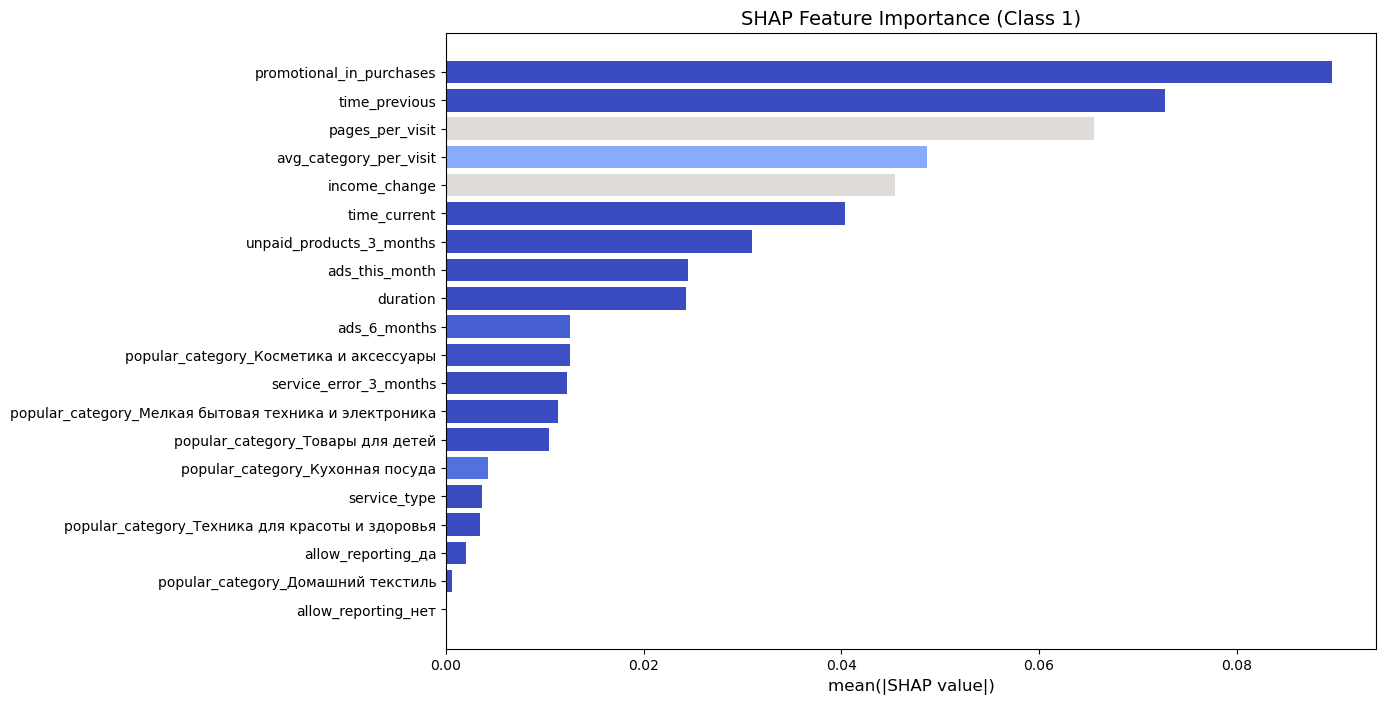

In [79]:
# вычисляем абсол.средние SHAP-значения для класса 1
shap_values_class1 = shap_values[:, :, 1]
mean_abs_shap = np.abs(shap_values_class1.values).mean(0)

# создаем цветовую карту 
mean_shap = shap_values_class1.values.mean(0)
colors = plt.cm.coolwarm(mean_shap / np.max(np.abs(mean_shap))) 

# Сортируем признаки по важности
sorted_idx = mean_abs_shap.argsort()[::-1]
sorted_features = np.array(feature_names)[sorted_idx]
sorted_abs_values = mean_abs_shap[sorted_idx]
sorted_mean_values = mean_shap[sorted_idx]
sorted_colors = colors[sorted_idx]

# создаем bar-plot
plt.figure(figsize=(12, 8))
bars = plt.barh(sorted_features[:20], sorted_abs_values[:20], color=sorted_colors[:20])
plt.gca().invert_yaxis()
plt.title('SHAP Feature Importance (Class 1)', fontsize=14)
plt.xlabel('mean(|SHAP value|)', fontsize=12)
plt.show()

In [80]:
# также выведем средние SHAP значения для каждого признака
shap_df = pd.DataFrame({
    'Feature': feature_names,
    'Mean_SHAP': shap_values[:, :, 1].values.mean(0),
    'Abs_Mean_SHAP': np.abs(shap_values[:, :, 1].values).mean(0)
})

# сортируем по важности
shap_df = shap_df.sort_values('Abs_Mean_SHAP', ascending=False)

shap_df.head(20)

,Feature,Mean_SHAP,Abs_Mean_SHAP
12,promotional_in_purchases,-0.030220,0.089643
17,time_previous,-0.051399,0.072779
16,pages_per_visit,0.026257,0.065567
13,avg_category_per_visit,0.012059,0.048661
19,income_change,0.026264,0.045384
18,time_current,-0.028695,0.040402
14,unpaid_products_3_months,-0.013822,0.030933
10,ads_this_month,-0.015409,0.024462
11,duration,0.000199,0.024253
9,ads_6_months,0.002315,0.012538


**Вывод по анализу важности признаков:**


1. Позитивное влияние:
* `pages_per_visit`. Средний SHAP: +0.0183, то есть чем больше страниц просматривает клиент, тем выше вероятность активности
* `avg_category_per_visit`. Средний SHAP: +0.0071, чем больше категорий просматривает клиент, тем выше вероятность покупки. 
* `income_change`. Средний SHAP: +0.015591: чем больше измнения выручки текущего месяца с прошлым, тем выше вероятность покупки.   
Ожидаемое поведение - заинтересованные клиенты изучают больше страниц и повышают средний чек покупок.

2. Негативное влияние: 
* `promotional_in_purchases`. Средний SHAP: -0.0178, то есть чем больше покупок по акциям, тем меньше вероятность активности покупателя. Возможно клиенты, покупающие только по скидкам, менее лояльны (данное наблюдение уже упоминалось). 
* `time_previous`. Средний SHAP: -0.0517, то есть чем больше времени клиент провел на сайте в прошлом месяце, тем меньше вероятность текущей активности. Возможно, активные покупатели быстро совершают покупки, а клиенты, долго сидящие на сайтах могут проводить так время, а не из-за реальной нужды в покупках.
* `time_current`. Средний SHAP: -0.0174, то есть чем дольше текущая сессия, тем меньше вероятность покупок, возможно, это показатель "блуждания" без покупок.
* `popular_category`. Средний SHAP: -0.0123, то есть чем больше у покупателя популярных категорий, тем меньше вероятность покупок, вероятно, самые покупающие - это клиенты, которые часто заказывают один тип товаров, например, детские товары. 


3. Слабые признаки: `service_type`, `allow_reporting`.

Итоги анализа: 
1. Факторы  снижения вероятности покупки: 
    - слишком долгие сессии на сайте `time_current`
    - покупки в основном только по акциям `promotional_in_purchases`
    - долгие визиты сайта в прошлом месяце `time_previous`
    - большое количесвто популярных категорий `popular_category`
    

2. Факторы, повышающие вероятность покупки:
    - Просмотр многих страниц `pages_per_visit`
    - Изучение разных категорий `avg_category_per_visit`
    - Положительное изменение дохода `income_change`
    
    
3. Нейтральные факторы:
    - количество неоплаченных товаров  за 3 мес.`unpaid_products_3_months`
    - ошибки сервиса  за 3 мес.`service_error_3_months`
    - тип сервиса `service_type`
    - длительность регистрации `duration`
    - разрешение присылать предложения о товаре `allow_reporting_нет`
    - релама за 6 месяцев и в этом месяце `ads_6_months` и `ads_this_month`	

Также проведем анализ `Beeswarm Plot` по SHAP значениям:

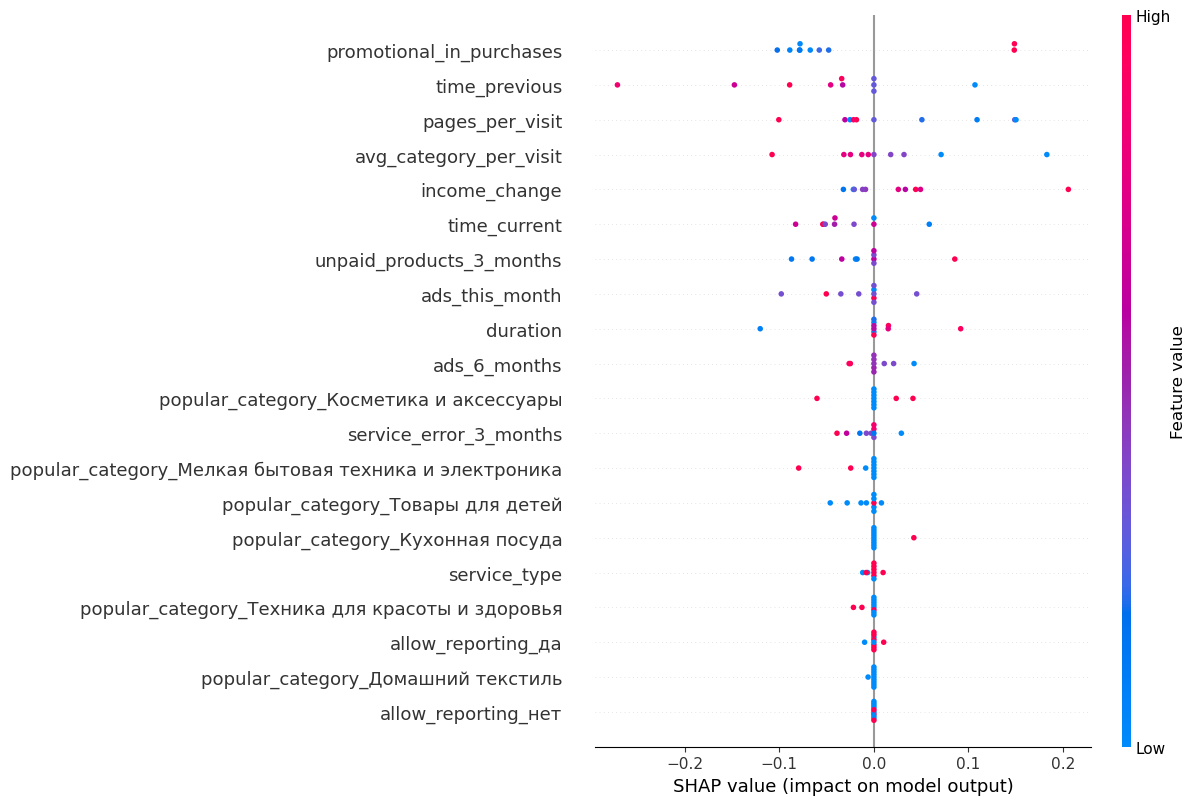

In [81]:
# вычисляем важность признаков (SHAP value)
feature_order = np.argsort(np.sum(np.abs(shap_values[:, :, 1].values), axis=0))[::-1]

# строим график признаков SHAP: Beeswarm Plot
plt.figure(figsize=(12, 10))
shap.plots.beeswarm(
    shap_values[:, :, 1],
    max_display=20,
    order=feature_order[:20],  # только топ-20 признаков
    show=False
)
plt.show()

**Вывод по анализу Beeswarm Plot по SHAP значениям.**

Самые важные признаки и их влияние:
* `promotional_in_purchases` (промо-покупки в общей доле покупок). Низкие синие значения и высокие красные значения: значит сильное отрицательное влияние. Подтверждена теория о том, что клиенты с малым количеством покупок по акциям чаще являются активными покупателями. Чрезмерное использование акций может снижать лояльность.

* `time_previous` (время на сайте в предыдущем месяце). Низкие синие значения высокие и высокие красные значения: отрицательное влияние. гипотеза подтвердилась: чем больше времени клиент провел на сайте в прошлом месяце, тем меньше вероятность текущей активности. Возможно, активные покупатели быстро совершают покупки, а клиенты, долго сидящие на сайтах могут проводить так время, а не из-за реальной нужды в покупках.

* `pages_per_visit` (страниц за визит). Высокие синие значения и низкие красные значения: сильное положительное влияние. Клиенты, просматривающие много страниц, чаще совершают покупки. Это показатель высокой заинтересованности.

* `time_current` (время на сайте за текущий визит). Низкие синие значения и высокие красные значения: отрицательное влияние. Долгие сессии коррелируют с меньшей вероятностью покупки. Возможно, клиенты "теряются" на сайте, либо просто проводят время, но не делают покупки. 

* `avg_category_per_visit` (категорий за визит). Высокие синие значения -  положительное влияние и низкие красные. Изучение и просмотр товаров из разных категорий - позитивный сигнал.
* `income_change`(измнение выручки) -  положительное влияние. Измнение выручки - позитивный сигнал, чем больше измнение выручки, тем выше покупательская активность.


Неожиданные наблюдения:

* Парадокс времени, проведенного на сайте: как время на сайте в прошлом месяцу `time_previous`, так и время на сайте в текущем месяце `time_current`  имеют отрицательную корреляцию с активностью покупок. Гипотеза: Активные покупатели тратят меньше времени на покупки, значит, знают что хотят купить. 

* Промо-акции прохо влияют на покупательскую активность: `promotional_in_purchases` - самый важный признак с негативным влиянием. Рекомендуется пересмотреть стратегию промо-акций. 

* Факторы. незначительно влияющие на покупательскую активность: `ads_this_month`, `service_error_3_months` почти не влияют на предсказание, `service_type` и `allow_reporting` имеют минимальное влияние.

### Выводы о значимости признаков.

1. Мало значимые признаки для модели:
* рекламные метрики: `ads_this_month`, `ads_6_months` очень мало влияют на активность покупателей. 
* технические параметры: `service_error_3_months`, `service_type` (ошибки сервиса и тип сервиса)
* персональные настройки: `allow_reporting`, `duration`  - разрешение на рассылку и длительность регистрации.
* unpaid_products_3_months - неоплаченные товары.

Эти признаки можно исключить из модели для упрощения без потери качества прогноза.

2. Ключевые признаки, влияющие на покупательскую активность:

* доля промо-покупок имеет сильное негативное влияние: чем выше - тем хуже,	
* время на сайте в прошлом месяце имеет негативное влияние,	
* количество просмотренных страниц имеет сильное позитивное: чем больше - тем лучше,
* время на сайте в текущем месяце имеет негативное влияние: чем выше - тем хуже,	
* просмотр товаров из разных категорий имеет позитивное влияние.	
* измнение выручки к текущему месяцу имеет позитивное влияние.

3. Рекомендации для моделирования:
* упростить модель, удалив наименее значимые признаки
* обратить внимание на нелинейные зависимости, особенно для времени на сайте.
* также можно обавить новые производные признаки:, например, изменение поведения = `time_previous` - `time_current`

Рекомендации для бизнес-решений: 
* разработать персональные рекомендации товаров
* ввести лимиты на промо-покупки, чтобы уменьшить спад лояльности постоянных клиентов, покупающих только по акциям
* создать эксклюзивные предложения для премиум-клиентов, например, бесплатная доставка
* внедрить надрады за просмотр страниц, например, баллы за каждый просмотр категории
* улучшение удобства сайта, в том числе при процесах покупки
* сделать сегментацию покупателей

## Сегментация покупателей

### Сегментация покупателей по результатам моделирования и данным о прибыльности клиентов.

Используя результаты моделирования и анализа признаков, мы сделали вывод, что самым главным фактором, влияющим на покупательскую активность, является доля акционных покупок. 

Шаги для сегментации покупателей:

*  объединить основной датафрейм с прибылью для анализа 
*  выделить критерии сегментации у клиентов по вероятности снижения покупательской активности (по прогнозу). 
*  выделить критерии сегментации у покупателей с долей покупок по акциям
*  выделить критерии сегментации у покупателей с разной прибылью 
*  сделать сегментацию по 3 осям: доля покупок по акции (как ключевой негативный фактор), прибыльность клиента, зона высокого риска снижения покупательской активности. 

Объединим таблицы `merged_df` и `money`, предварительно проверив количество строк таблиц до объединения. 

Для объединения используем метод `merge()` и параметр `left` для того, чтобы сохранить все записи в 3 датафреймах, а колонки `client_id` из всех таблиц будут объединены в одну.

In [82]:
# проверим длины датафреймов до объединения
print(f"Длина датафрема 'merged_df': {len(merged_df)} строк(и), " 
      f"'money': {len(money)} строк(и) ")

Длина датафрема 'merged_df': 1297 строк(и), 'money': 1300 строк(и) 


In [83]:
merged_df = merged_df.merge(money, on='client_id', how='left')

In [84]:
# проверим появились ли после объединения пропуски 
display(
    isna_table(merged_df).set_caption("Данные интернет-магазина")) 

len(merged_df) # проверим длину нового датасета после объединения

,0
client_id,0.000000
buyer_activity,0.000000
service_type,0.000000
allow_reporting,0.000000
ads_6_months,0.000000
ads_this_month,0.000000
duration,0.000000
promotional_in_purchases,0.000000
popular_category,0.000000
avg_category_per_visit,0.000000


1297

Объединение таблиц `merged_df` и `money` произведено успешно, количество строк таблиц после объединения = 1297.

In [85]:
# добавим в датасет вероятность снижения покупательской активности
best_model = randomized_search.best_estimator_
merged_df['predict_activity_gets_lower'] = best_model.predict_proba(X)[:,1]

# создаем флаг высокого риска снижения
merged_df['high_risk'] = merged_df['predict_activity_gets_lower'] > 0.7

Создадим сегментацию покупателей по трем ключевым измерениям: 
* доля покупок по акции (как ключевой негативный фактор) 
* прибыльность клиента 
* зона высокого риска снижения покупательской активности. 

In [86]:
# критерии сегментации обозначим по 75 квантилю 
promo_threshold = merged_df['promotional_in_purchases'].quantile(0.75)
profit_threshold = merged_df['profit'].quantile(0.75)

In [87]:
# создадим сегменты
conditions = [
    # зона максимального риска (фокус)
    (merged_df['promotional_in_purchases'] > promo_threshold) & 
    (merged_df['profit'] > profit_threshold) & 
    merged_df['high_risk'],
    
    # перспективные кандидаты на удержание
    (merged_df['promotional_in_purchases'] > promo_threshold) & 
    (merged_df['profit'] > profit_threshold) & 
    ~merged_df['high_risk'],
    
    # риск потери прибыли
    merged_df['high_risk'] & 
    (merged_df['profit'] > profit_threshold),
    
    # стабильные покупатели с низкой прибылью
    ~merged_df['high_risk'] & 
    (merged_df['profit'] <= profit_threshold)
]
choices = [
    'Критический риск (фокус)',
    'Уязвимые VIP',
    'Риск потери прибыли',
    'Стабильные с низкой прибылью'
]
merged_df['segment'] = np.select(conditions, choices, default='Прочие')

### Анализ фокус-сегмента "Критический риск"

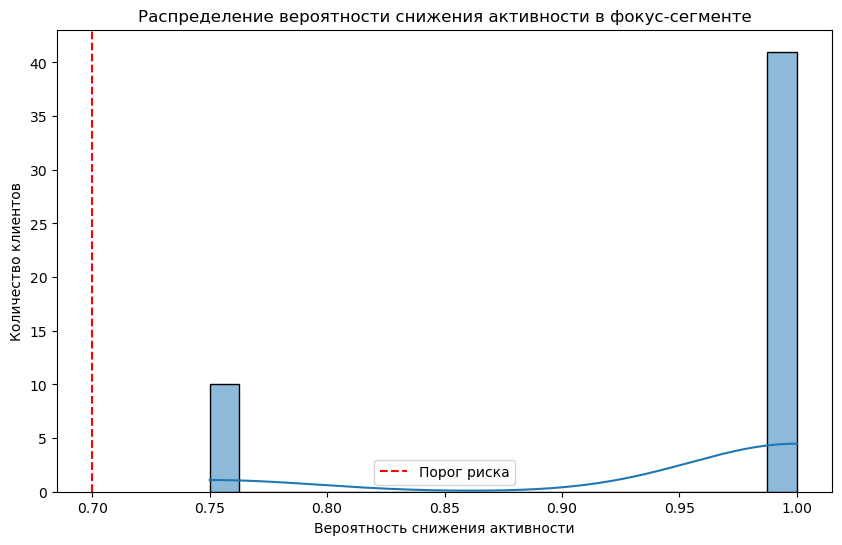

In [88]:
focus_segment = merged_df[merged_df['segment'] == 'Критический риск (фокус)']

# визуализация распределения риска
plt.figure(figsize=(10, 6))
sns.histplot(data=focus_segment, x='predict_activity_gets_lower', bins=20, kde=True)
plt.axvline(x=0.7, color='r', linestyle='--', label='Порог риска')  

plt.title('Распределение вероятности снижения активности в фокус-сегменте')
plt.xlabel('Вероятность снижения активности')
plt.ylabel('Количество клиентов')
plt.legend()
plt.show()

Двухмерная визуализация сегментов:

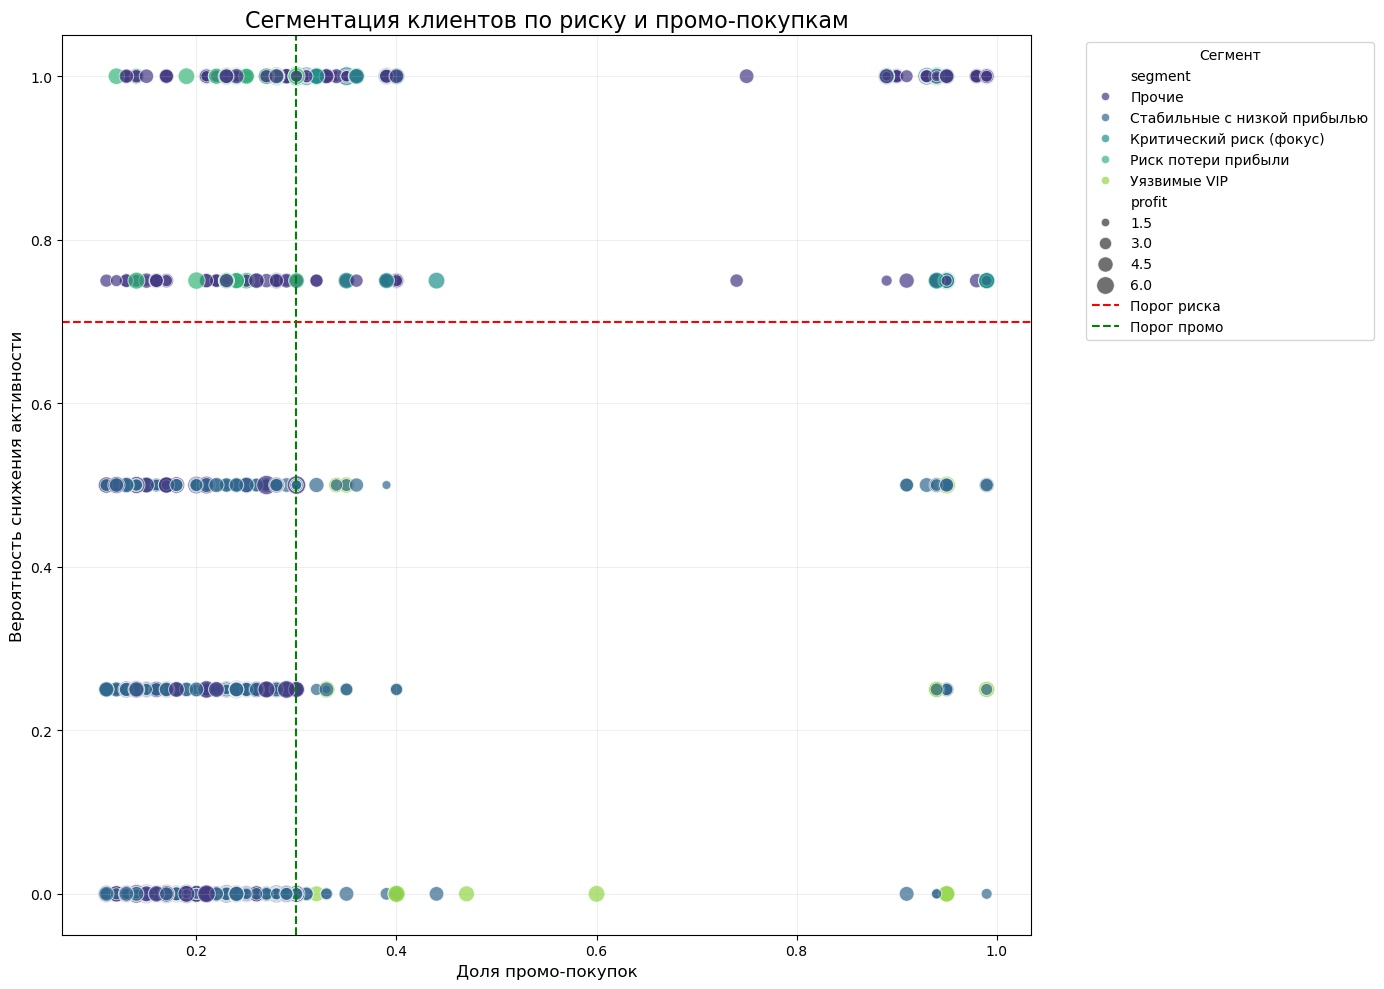

In [89]:
plt.figure(figsize=(14, 10))
sns.scatterplot(
    data=merged_df,
    x='promotional_in_purchases',
    y='predict_activity_gets_lower',
    hue='segment',
    size='profit',
    sizes=(20, 200),
    alpha=0.7,
    palette='viridis'
)

plt.axhline(y=0.7, color='r', linestyle='--', label='Порог риска')
plt.axvline(x=merged_df['promotional_in_purchases'].quantile(0.75), 
            color='g', linestyle='--', label='Порог промо')
plt.title('Сегментация клиентов по риску и промо-покупкам', fontsize=16)
plt.xlabel('Доля промо-покупок', fontsize=12)
plt.ylabel('Вероятность снижения активности', fontsize=12)
plt.legend(title='Сегмент', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

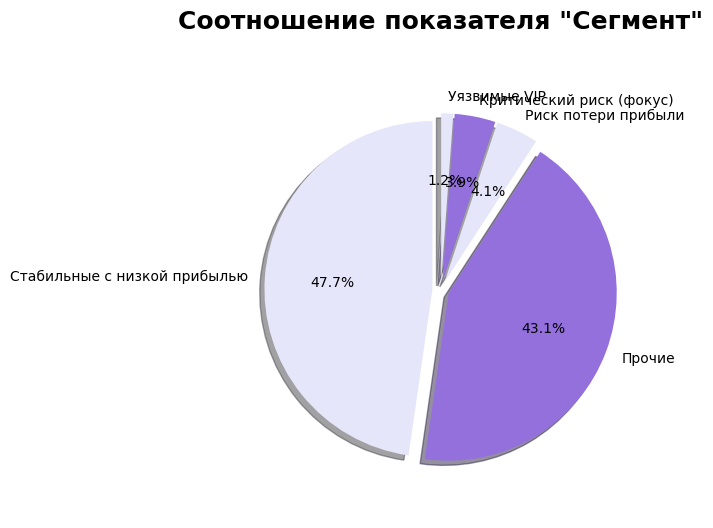

segment
Стабильные с низкой прибылью    619
Прочие                          559
Риск потери прибыли              53
Критический риск (фокус)         51
Уязвимые VIP                     15
Name: count, dtype: int64

In [90]:
# словарь для перевода английских названий на русский 
column_translations = {
    'segment': '"Сегмент"'}

# строим диаграммы для кат.признаков market_file
pie_chart(merged_df, ['segment'], column_translations)
merged_df['segment'].value_counts()

Портрет Исследуемого фокус-сегмента "Критический риск":

* Высокая доля промо-покупок (выше 75 квантиля)
* Высокая прибыльность (выше 75 квантиля)
* Высокий риск снижения активности: >70% вероятность

Проблемы сегмента:

* Высокая зависимость от скидок
* Риск потери наиболее прибыльных клиентов
* Низкая лояльность вне промо-акций

Предложения по удержанию клиентов и увеличеню покупательской активности:

* Персональные НЕпромо предложения: это поможет снизить промо-зависимости у покупателей. Ожидание:	уменьшение доли промо-покупок, увеличение НЕпромо-покупок. 
* Программа лояльности "Супер-премиум" - повысит интерес и  вовлеченность. Ожидание: увеличение просмотров страниц.
* Ускоренная навигация	и как следствие сокращение времени сессии на сайте и ускорение покупок. 
* Персональный менеджер и индивидуальный подход приведет с	снижению вероятности снижения покупательской активности. 

### Выводы о сегментах.


Распределение сегментов:

1. Доминирование массового сегмента: "стабильные с низкой прибылью" - самая большая группа составляет 56% клиентской базы харакерны низкой прибылью, но стабильными покупками.

2. Ключевой проблемный сегмент: "критический риск (фокус)" - небольшая, но критически важная группа составляет 3% клиентов. Приносит непропорционально высокую долю прибыли.

3. Переходная группа: "Уязвимые" - клиенты с хорошей прибылью, но риском снижения активности, они могут перейти либо в "Критический риск", либо в "Стабильные" путем правильного стимулирования.

4. Неопределенная категория: "Прочие" - требует дополнительного анализа. Могут содержать перспективные или проблемные подгруппы.

Предложения: 

1. Чтобы снизить риск потери прибыли нужно вести персональную менеджерскую работу с ключевыми высокоприбыльными клиентами ("Критический риск"), которые находятся в зоне ухода. Это важно: потому что хоть и сегмент малый, данные клиенты поставляют несоизмеримо большой процент прибыли.

2. Чтобы решить проблему неэффективности распределения ресурсов где основное внимание уделяется массовому сегменту ("Стабильные"), нужно сместить акцент внимания на немассого покупателя, так как большую часть прибыли может давать малая часть клиентов. 

Таким, образом сегмент "Уязвимые" не получает достаточного внимания, а "Прочие" не сегментированы, поэтому предлагается данные сегменты взять для дополнительного исследования.

**Вывод по этапу сегментирования покупателей.**

В ходе этапа сегментирования покупателей интернет-магазина быда реализовано:

* объединение основного датафрейма с данными и прибылью для анализ.а
* определение критериев сегментации у покупателй по 3 осям
* сегментация по 3 осям: доля покупок по акции (как ключевой негативный фактор), прибыльность клиента, зона высокого риска снижения покупательской активности.
* графики для визуализации сегментов и порогов вероятности снижения активности покупателей. 
* портрет исследуемого фокус-сегмента "Критический риск"
* предложения по удержанию клиентов и увеличеню покупательской активности
* выводы о сегментах.

## Общий вывод

1. Описание задачи:  
* детальное изучение данных и разработка модели машинного обучения для интернет-магазина «В один клик», которая поможет принимать объективное решение об удерживании активности постоянных клиентов.  Данная модель  призвана  спрогнозировать вероятность снижения покупательской активности клиентов и выделить сегменты покупателей в зоне риска. Данное решение позволяет персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность. 

2. Исходные данные и проведённая обработка данных:
* для исследовании использовались данные отдела цифровых технологий интернет-магазина «В один клик» из нескольких таблиц: данные о поведении покупателя на сайте,  данные о выручке, данные о времени на сайте, данные о  прибыли продавца за последние 3 месяца по каждому покупателю.
* в ходе предобработки данных были проверены  и исправлены типы данных, дубликаты и пропущенные значения в датасетах.
* в ходе исследовательского анализа был проведен статистический анализ данных, построена матрица корреляции признаков и были объединили датафремы о поведении покупателя на сайте,  о выручке и о времени на сайте (все кроме данных о прибыли). 
 
3. Для поиска лучшей модели был построен пайплайн, и с помощью него была выбрана лучшая модель. В ходе этапа создания пайплайнов была проведена следующая работа: 
* написан пайплайн обработки данных 
* обучены четыре модели и выбрана лучшая модель по метрике
* для оценки качества модели была выбрана метрика `ROC-AUC` и данное выбор был обоснован.

4. Наилучшей себя показала модель `KNeighborsClassifier` с гиперпараметрами: 
* для предобработки категориальных признаков использовался `OrdinalEncoder` и `OheHotEncoder`.
* метод масштабирования `StandardScaler`
* параметр `n_neighbors`= 29
* метрика ROC-AUC на тестовой выборке = 0.908.

5. Анализ важности признаков:
* наиболее важными признаком для прогноза активности оказались признаки которые описывают взаимодействие пользователя с сайтом - , количество просмотренных категорий за визит, количество открытых страниц, время проведенное на сайте, просмотренные категории. 
* также важнными признакми при прогнозе оказались признаки, описывающие характер покупок пользователей - покупки по акции, неоплаченные продукты и измнение выручки. 
* исторические и демографические признаки, типа длительности регистрации на сайте оказались менее важными. 

6. Выводы и дополнительные предложения для выбранного сегмента покупателей.

Так как важно было опередить ключевых высокоприбыльных клиентов, находящихся в зоне ухода, был определен фокус-сегмент "Критический риск" по 3 критеряим: 
* высокая доля промо-покупок (выше 75 квантиля)
* высокая прибыльность (выше 75 квантиля)
* высокий риск снижения активности: >70% вероятности риска снижения покупательской активности.

Рекомендации по работе с сегментами:
* "Критический риск (фокус)":
 - персональные менеджеры для каждого клиента
 - кастомные условия лояльности, не связанные с акциями
 - эксклюзивный доступ к новинкам
 
* "Уязвимые":
 - анализ причин уязвимости (опросы, анализ поведения)
 - программа профилактического удержания, например, предоставление бесплатной доставки на товары 
 - точечные предложения по повышению лояльности, например, также эксклюзивный доступ к новинкам

* "Стабильные с низкой прибылью":
 - массовые персонализированные предложения
 - повышение среднего чека через кросс-продажи
 
* Для "Прочие":
 - пополнительная кластеризация
 - выявление скрытых подгрупп

